In [1]:
import numpy as np
import pandas as pd
from os import path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Downloading the dataset

In [2]:
data = pd.read_csv(path.join('data', 'dataset_cybersecurity_michelle.csv'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129698 entries, 0 to 129697
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 110.8 MB


In [3]:
# Count how many -1 values are in each column
data.replace(-1, np.nan, inplace=True)
data.isnull().sum()

qty_dot_url                 0
qty_hyphen_url              0
qty_underline_url           0
qty_slash_url               0
qty_questionmark_url        0
                        ...  
qty_redirects           10739
url_google_index           92
domain_google_index        89
url_shortened               0
phishing                    0
Length: 112, dtype: int64

In [4]:
# substitute NaN with the most frequent value in the column
data.fillna(data.mode().iloc[0], inplace=True)

## Observing data

<Axes: xlabel='phishing'>

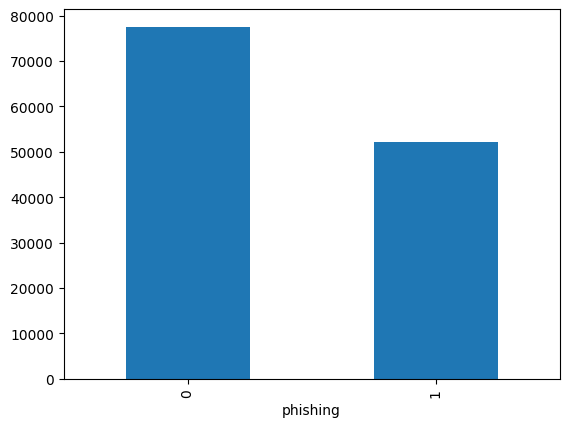

In [5]:
# plot the distribution of the target variable
data['phishing'].value_counts().plot(kind='bar')

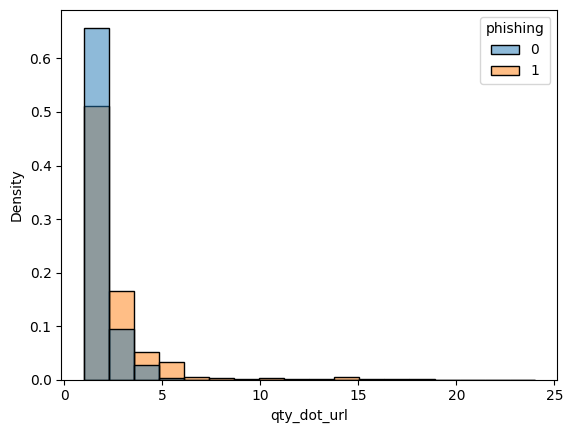

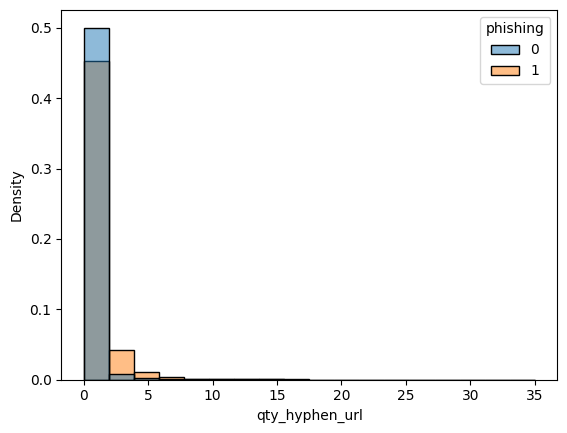

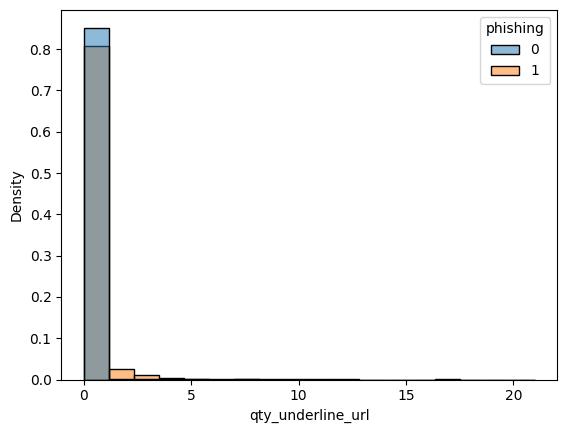

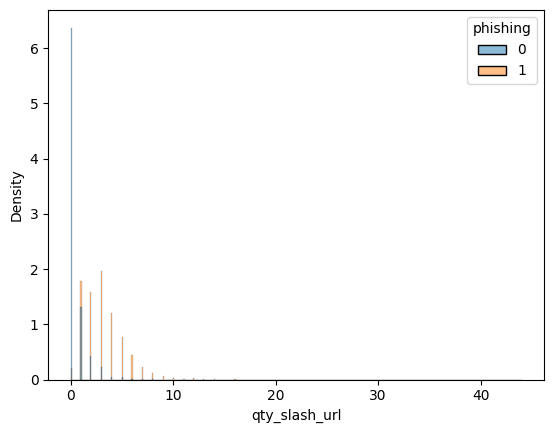

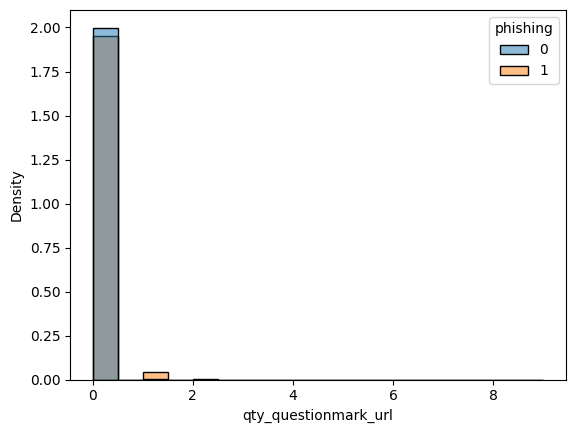

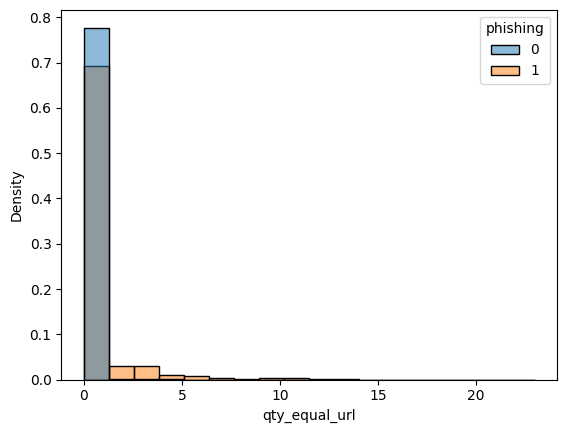

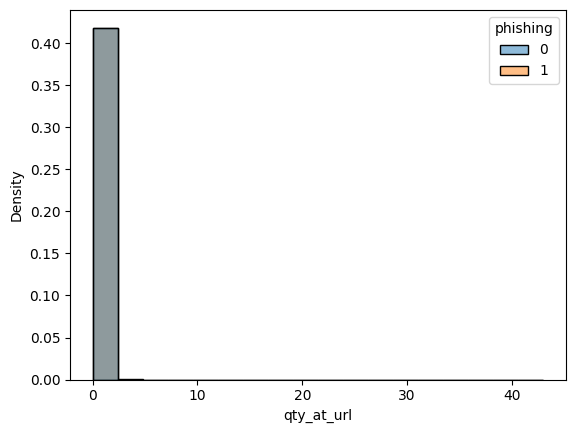

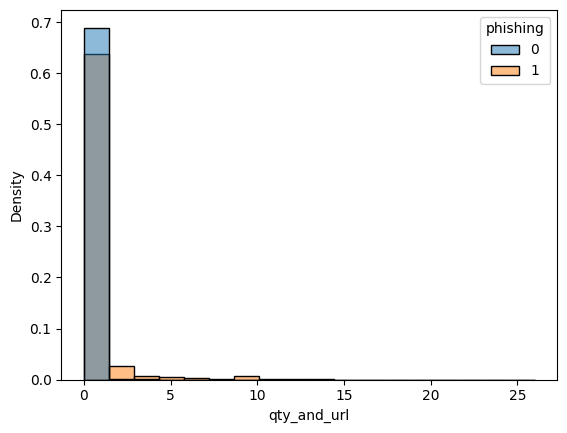

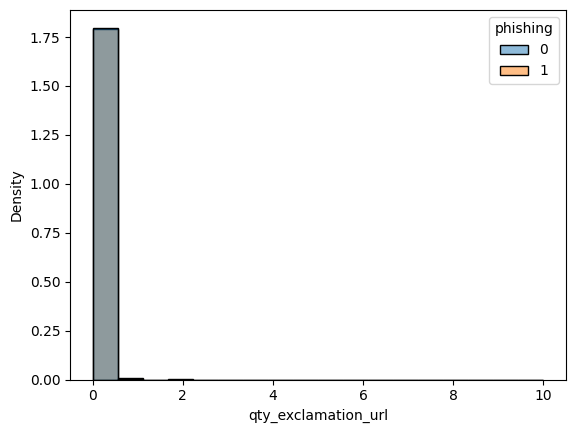

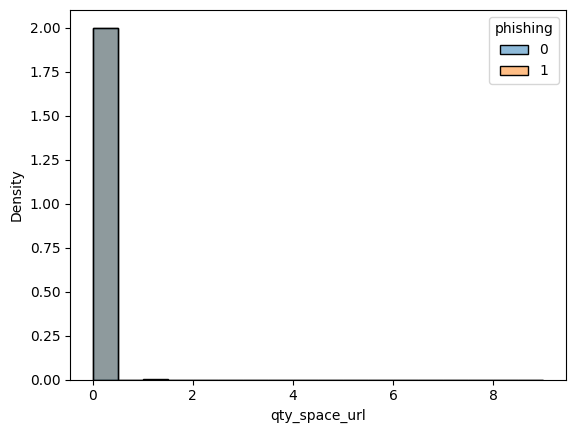

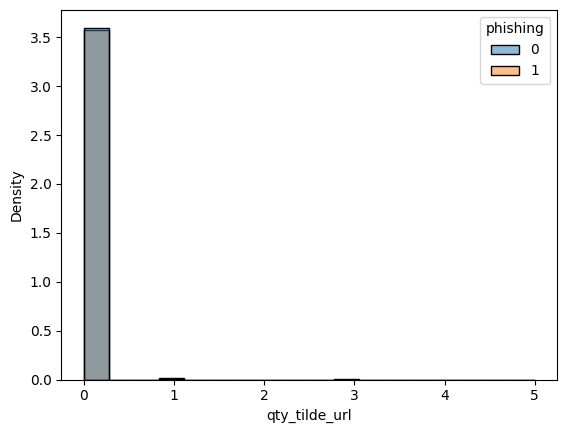

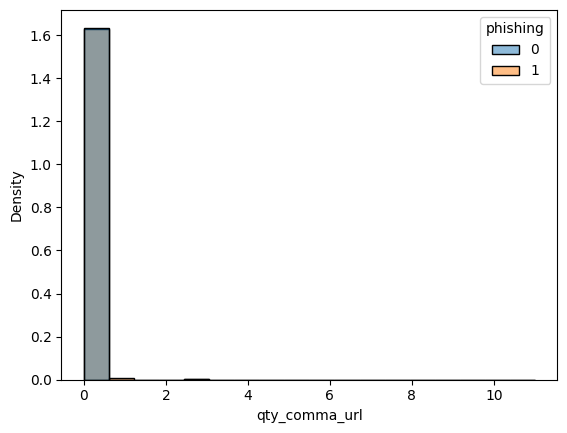

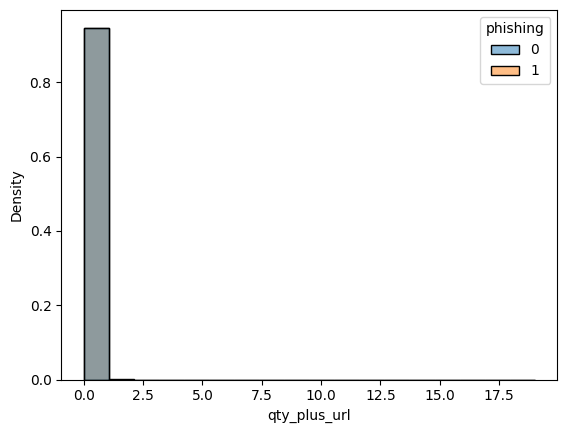

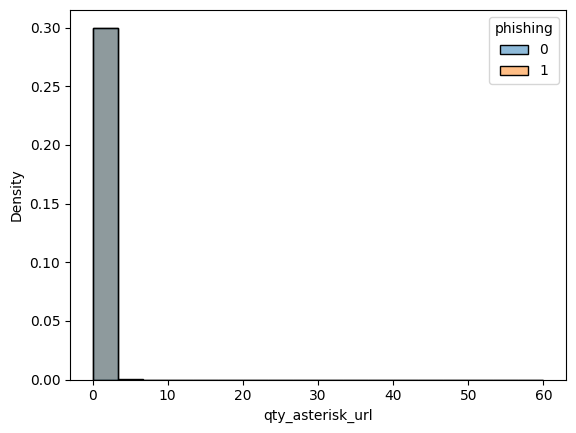

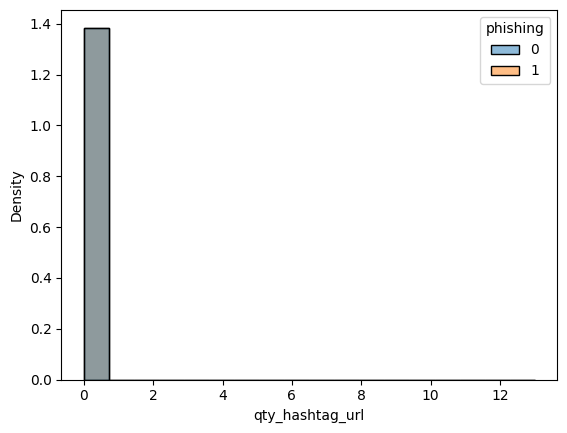

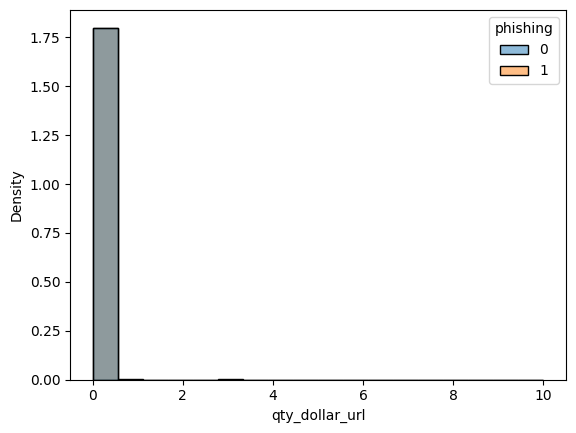

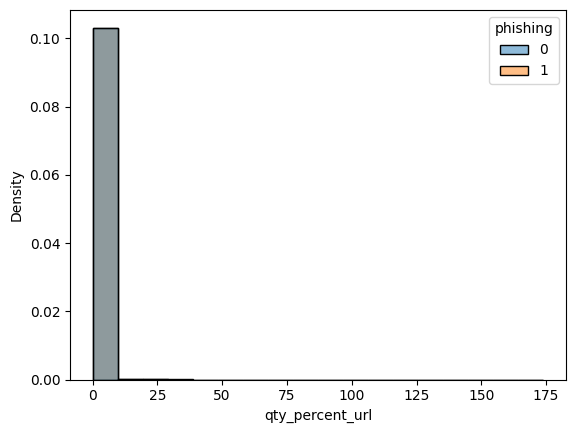

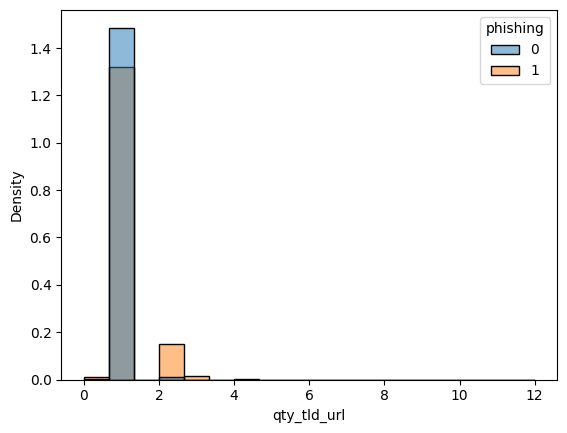

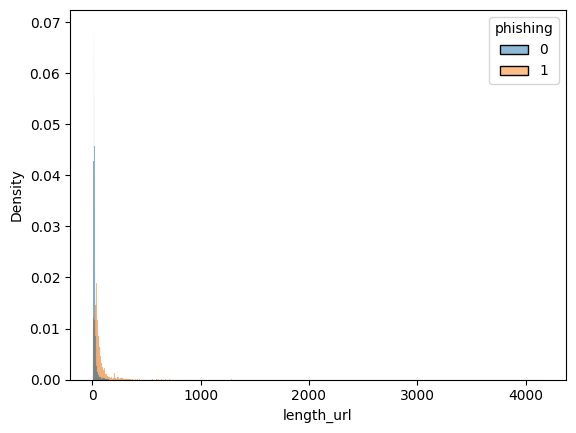

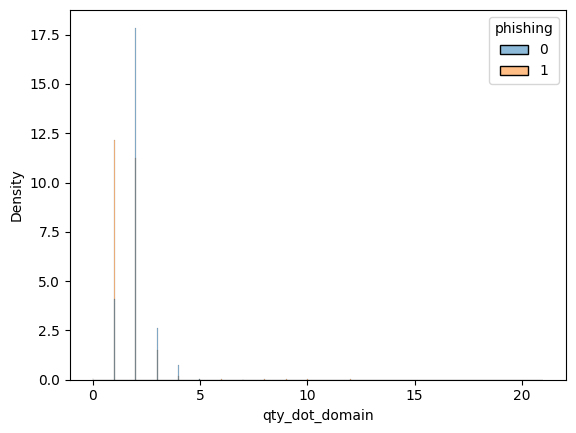

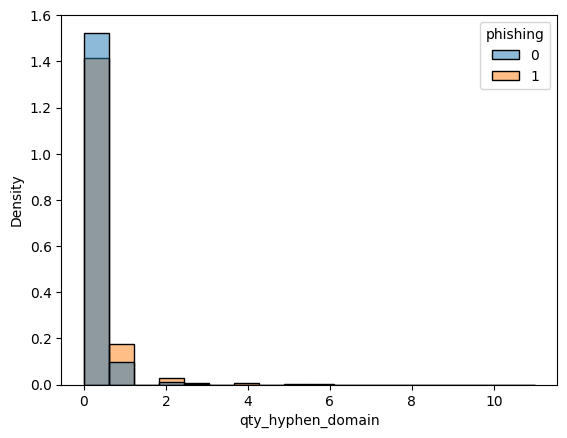

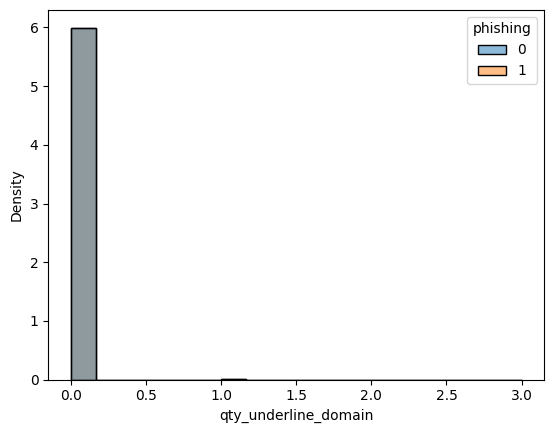

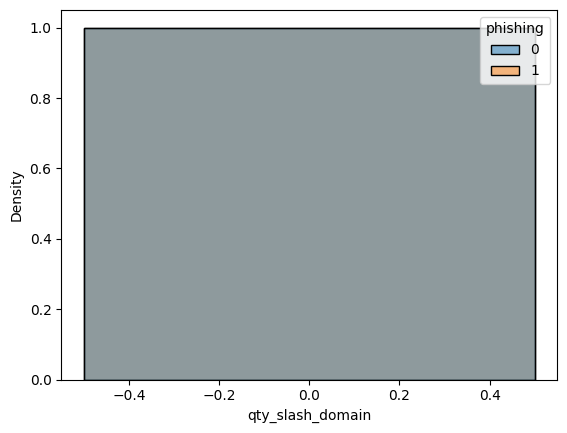

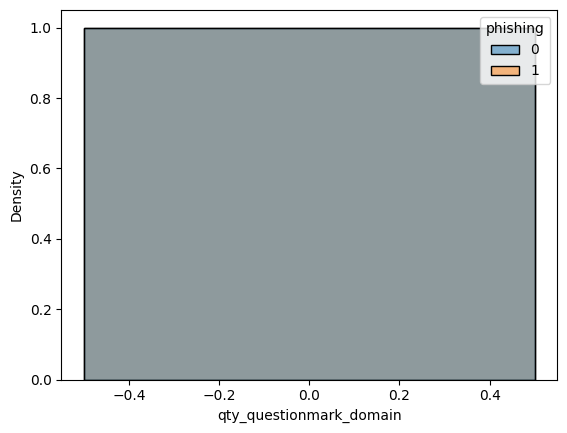

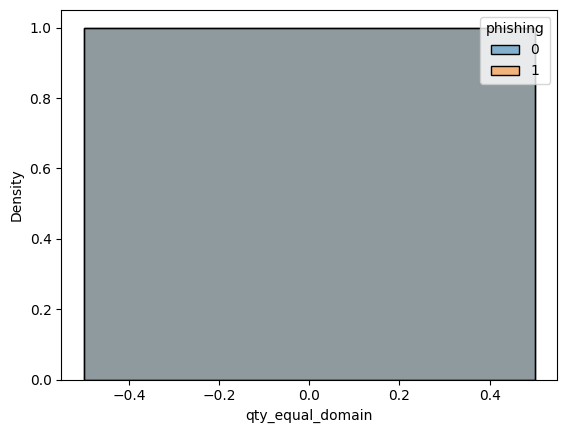

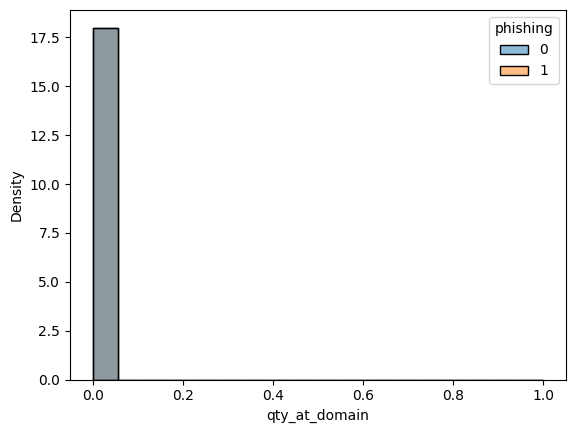

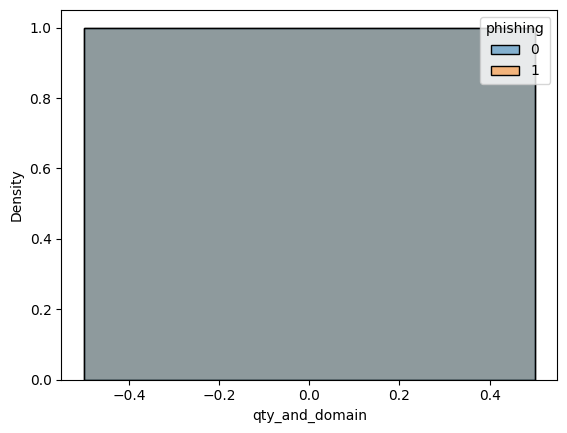

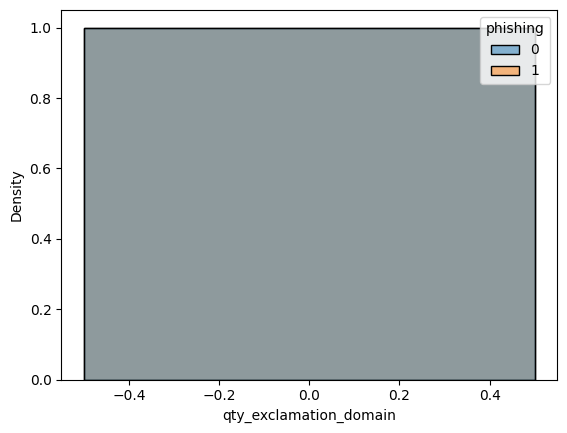

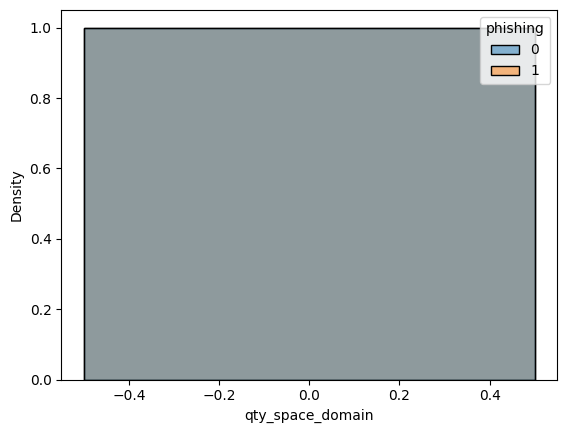

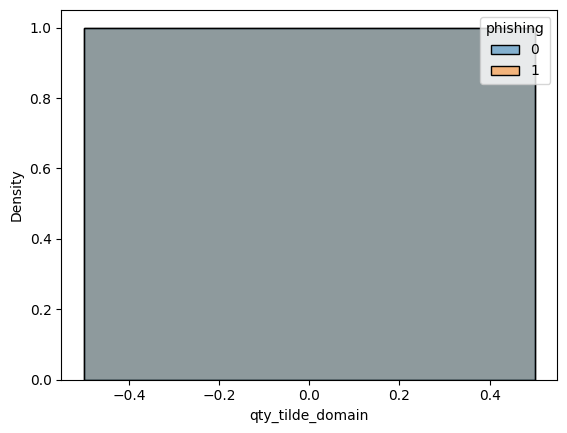

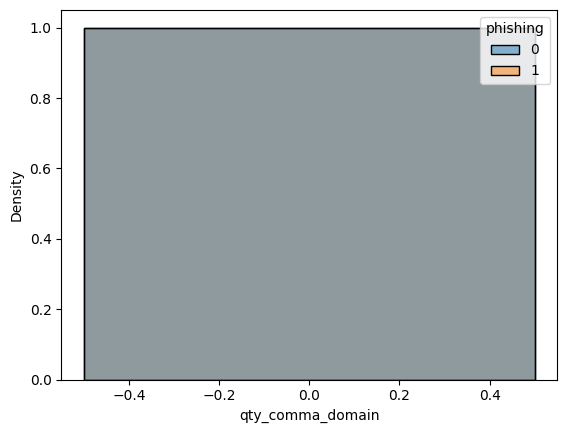

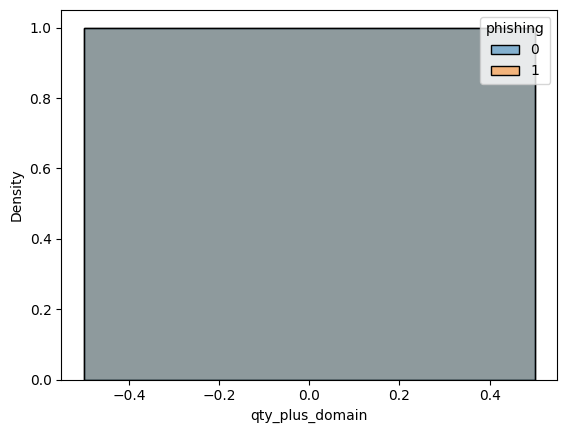

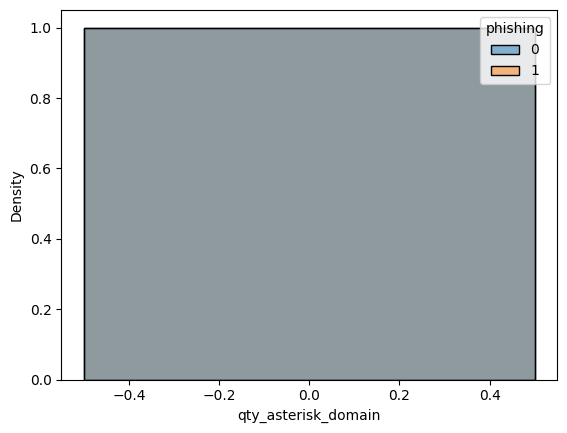

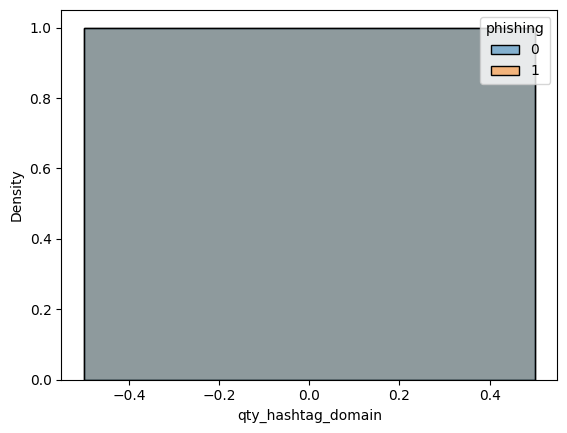

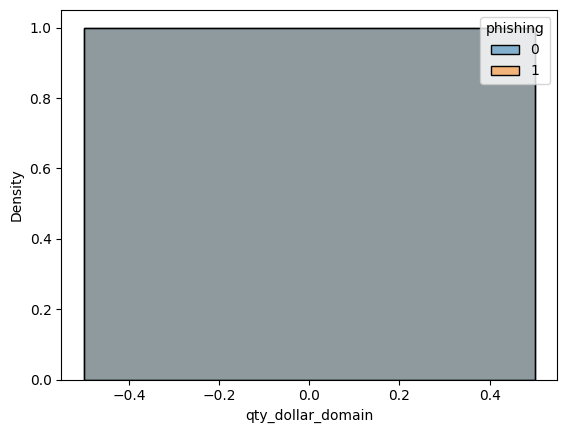

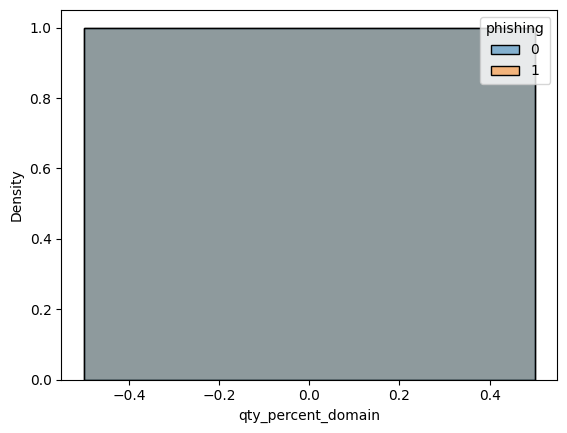

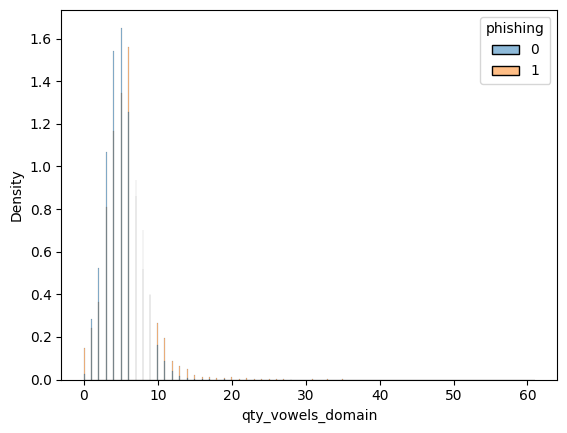

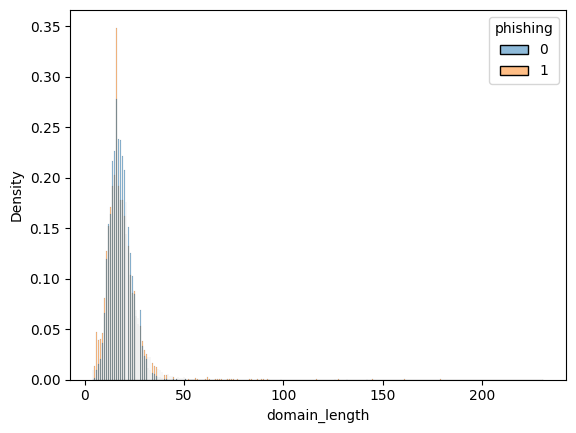

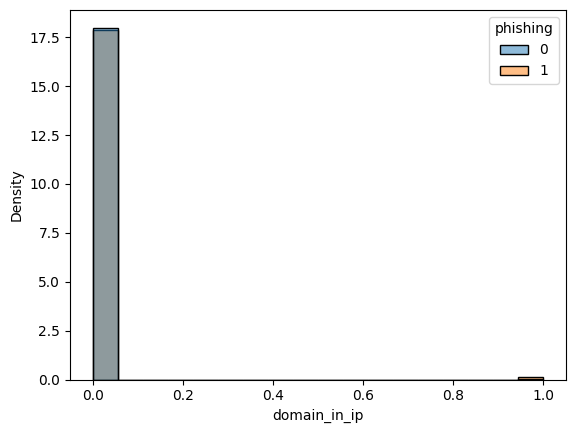

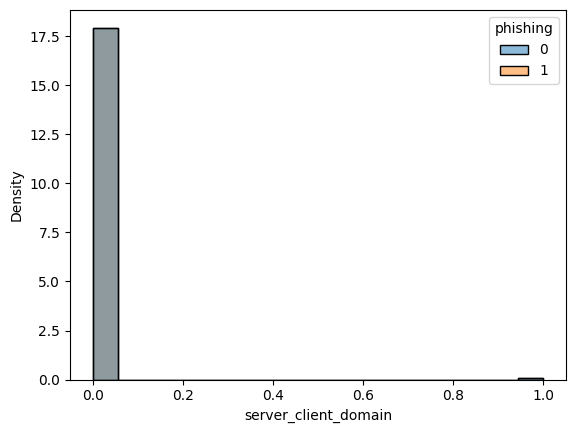

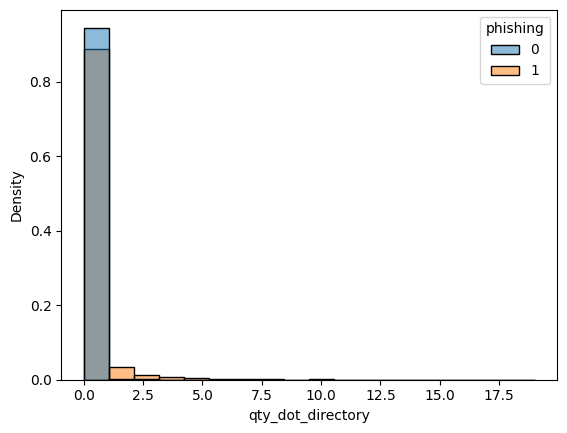

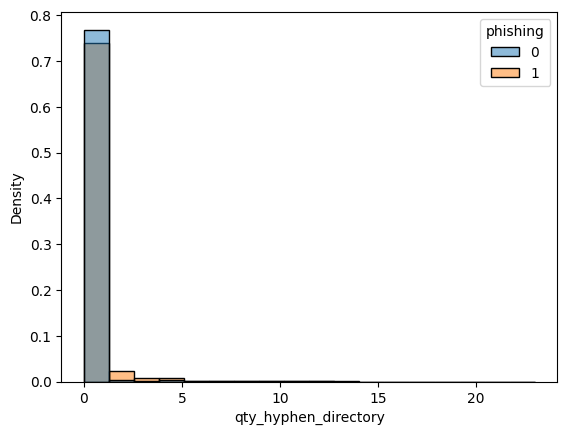

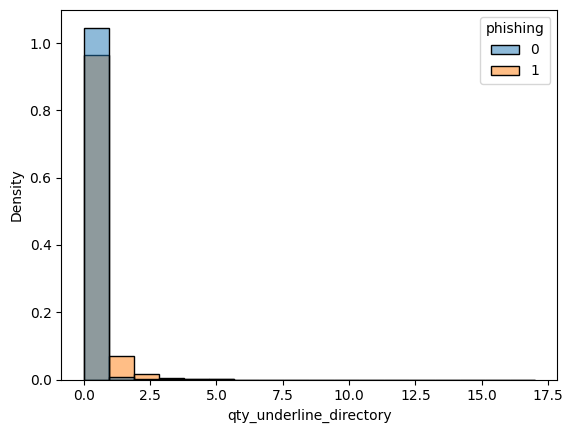

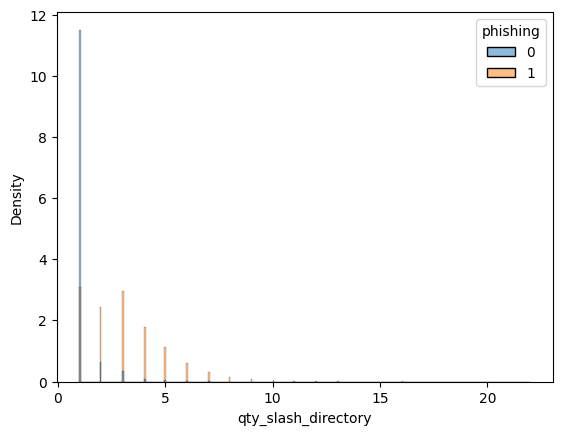

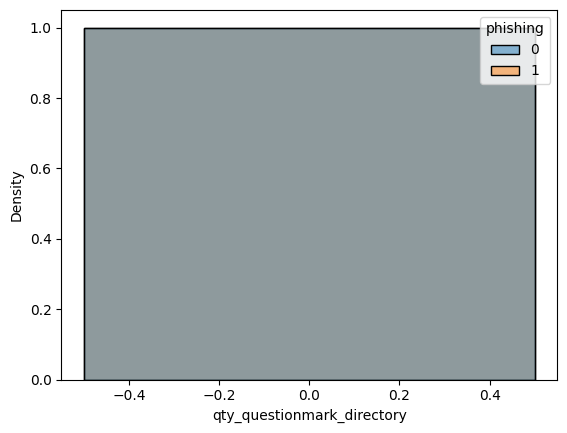

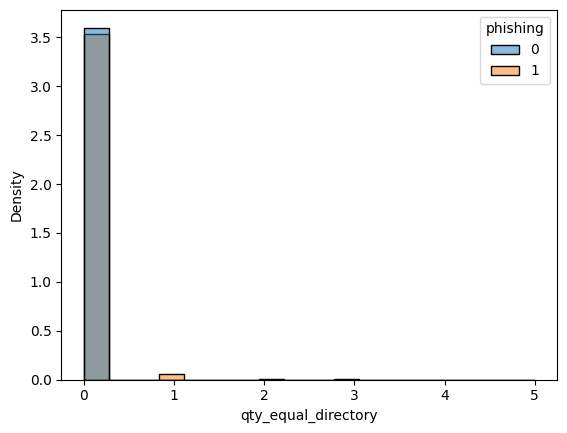

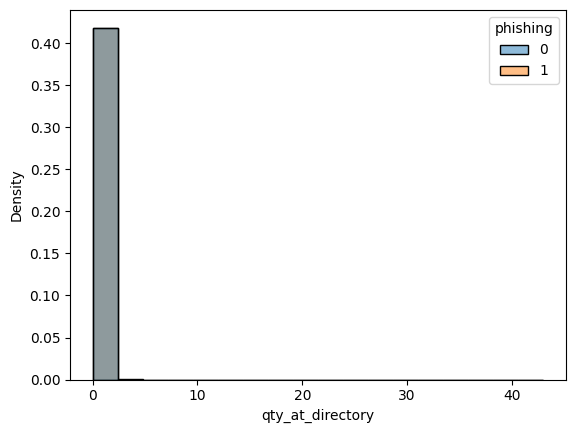

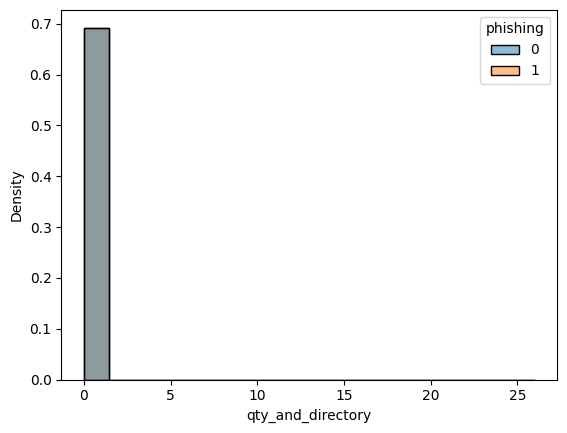

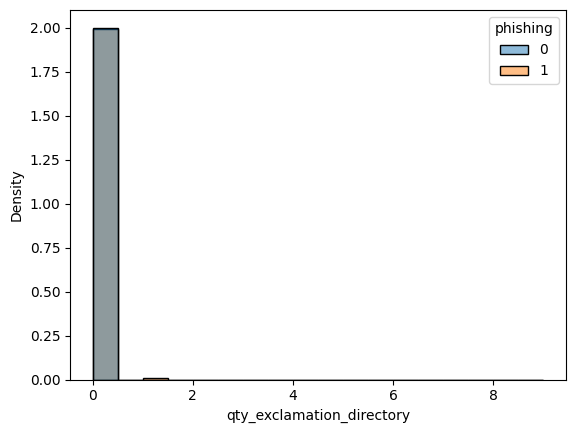

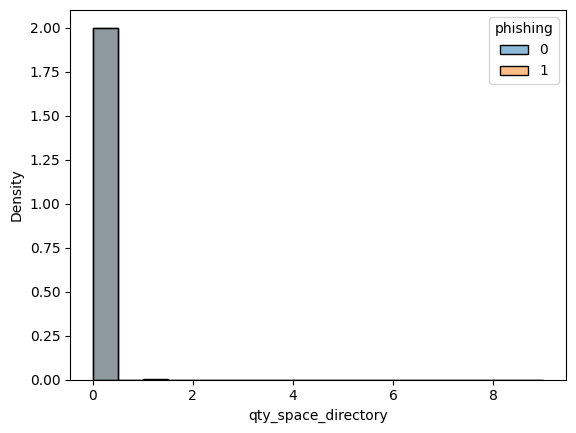

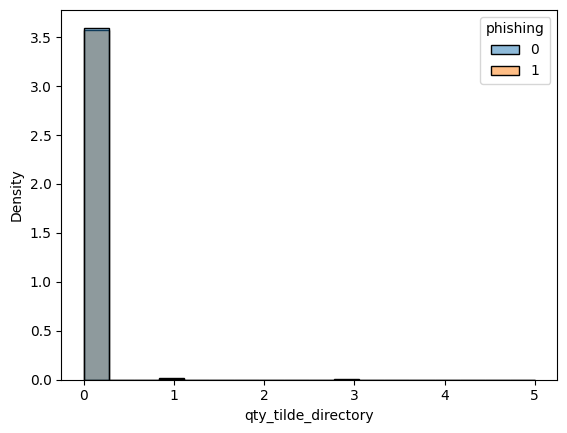

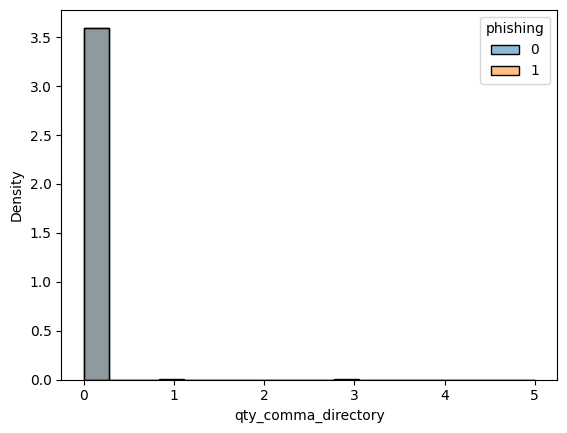

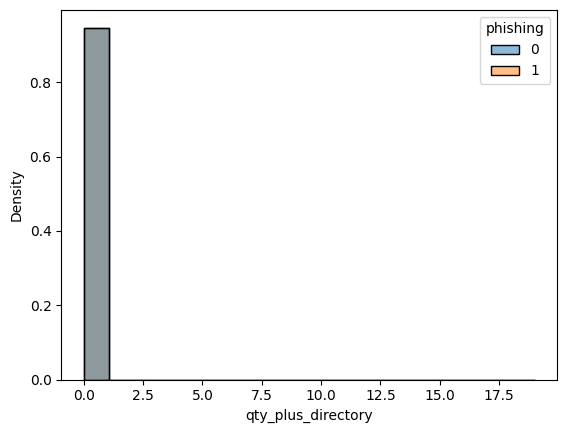

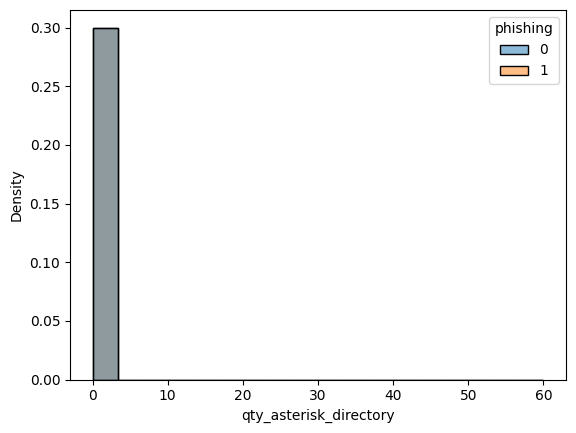

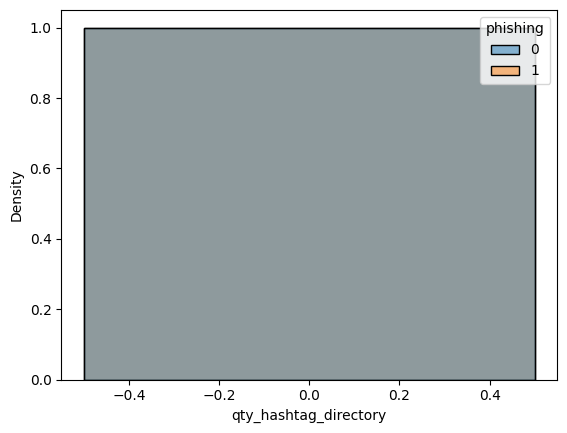

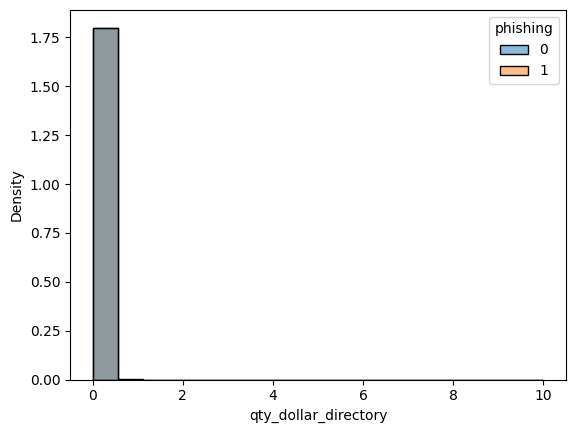

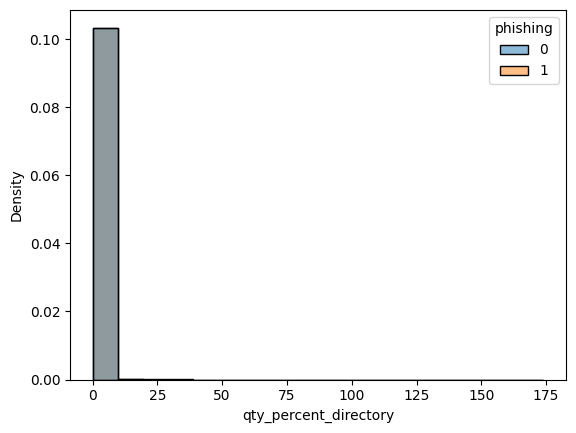

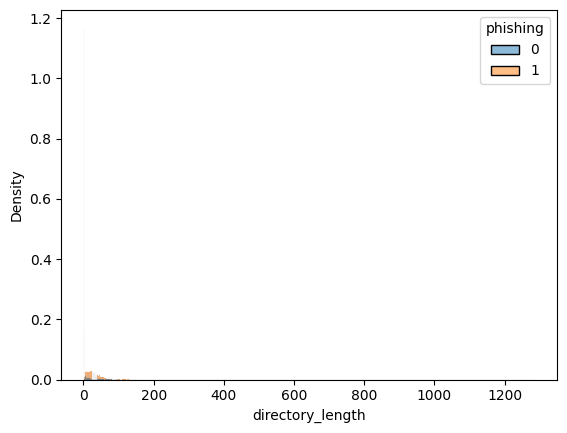

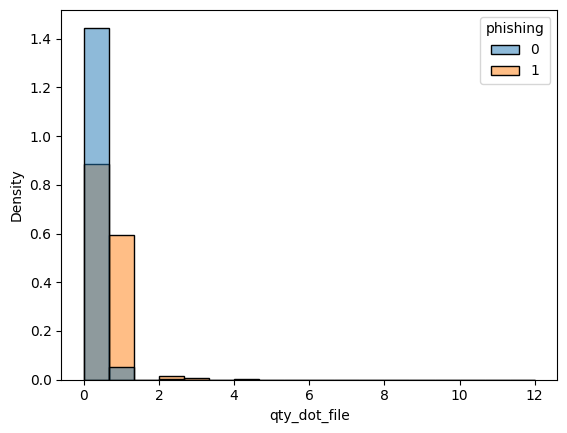

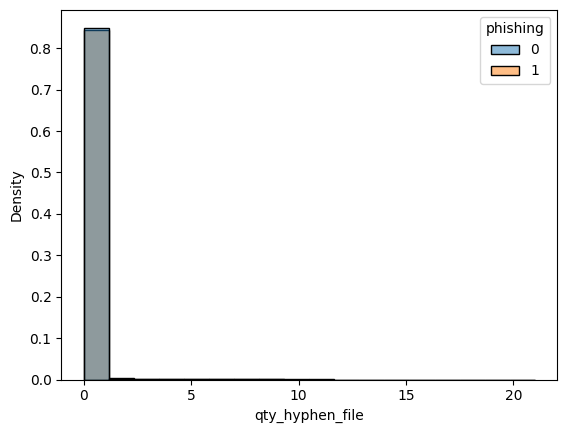

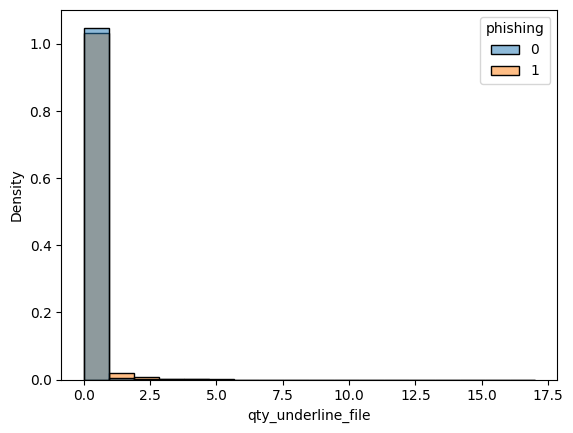

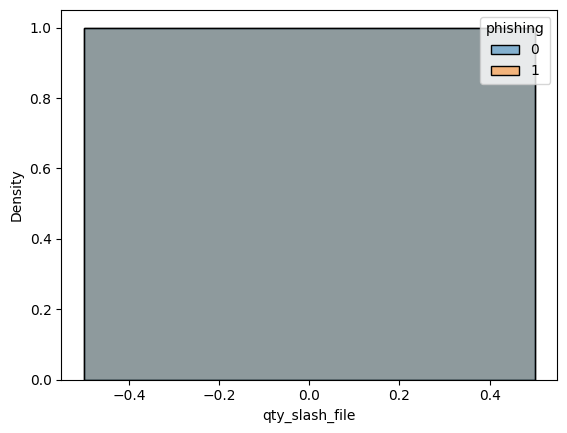

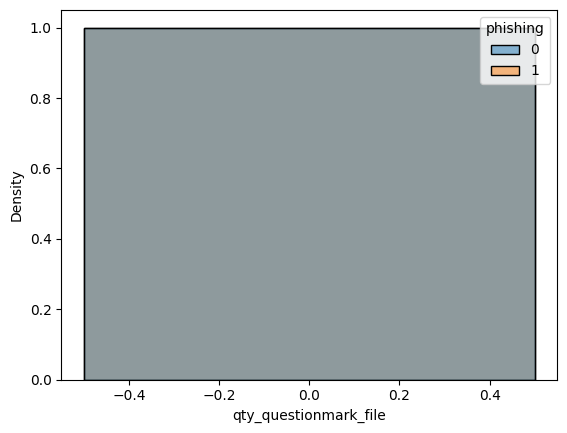

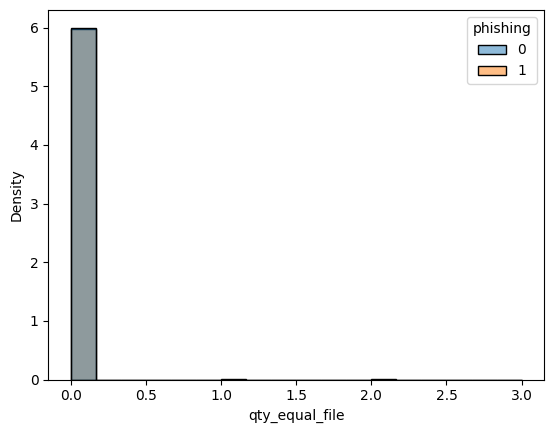

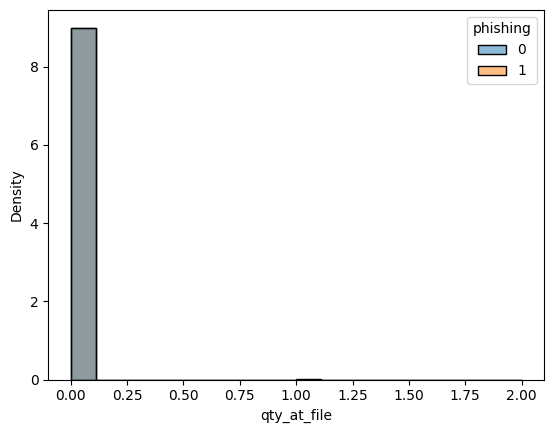

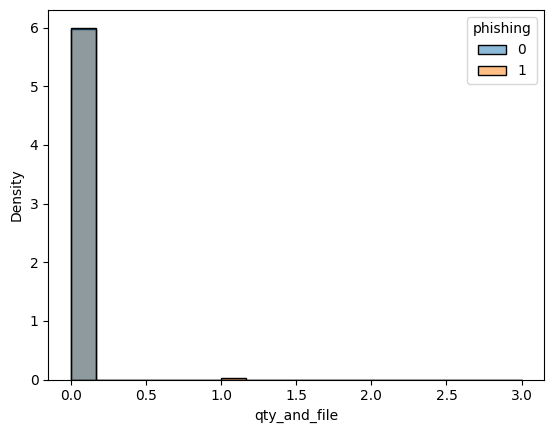

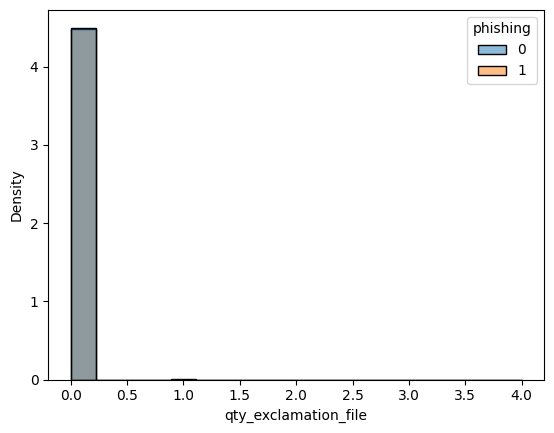

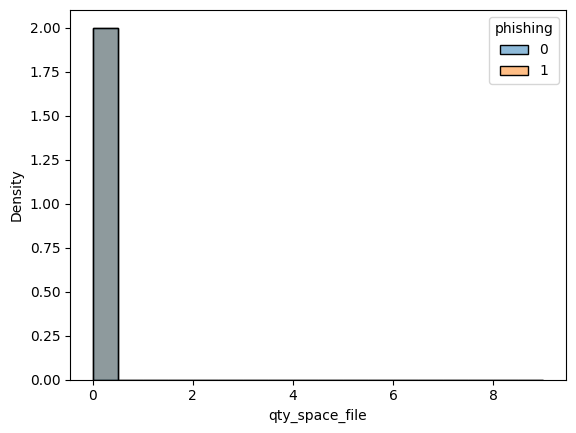

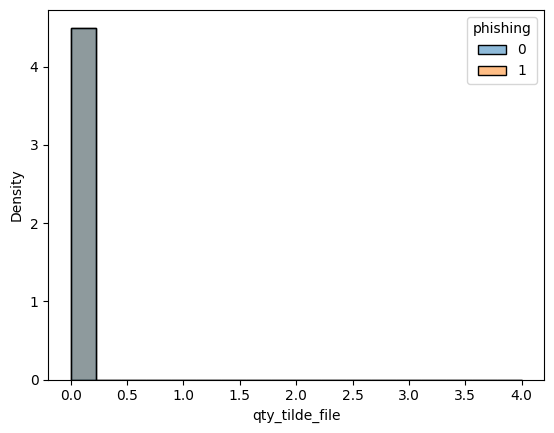

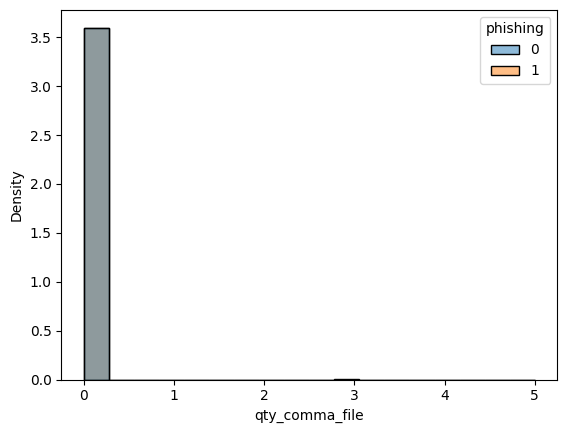

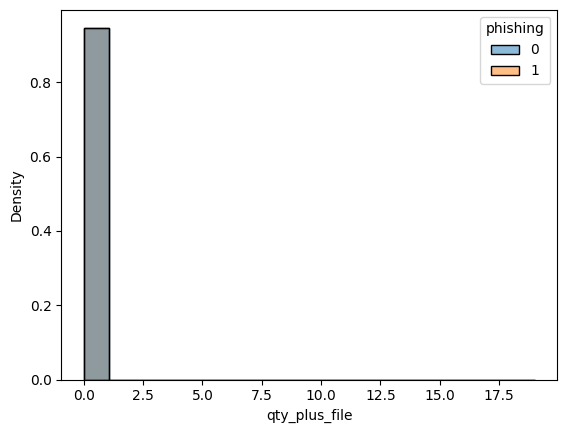

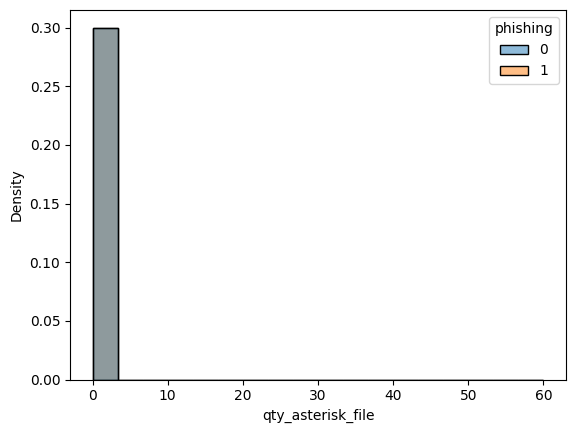

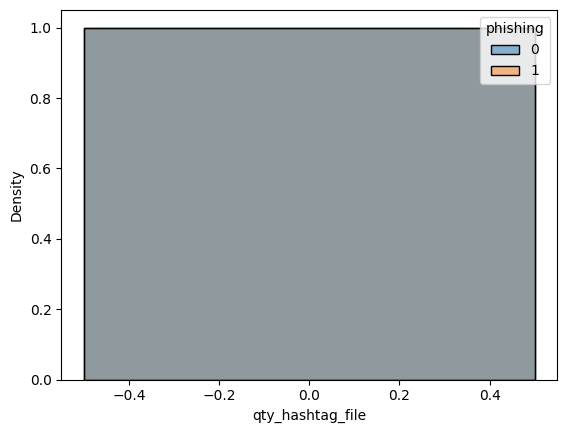

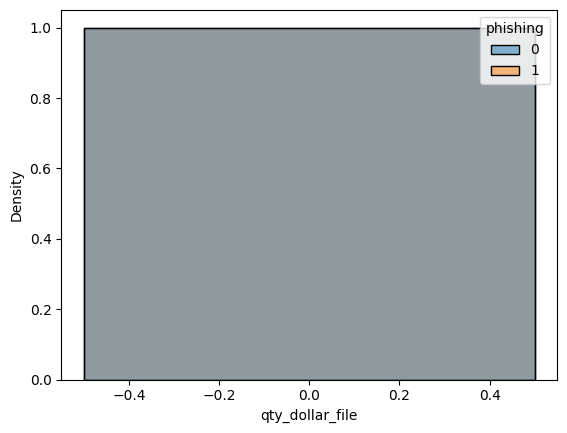

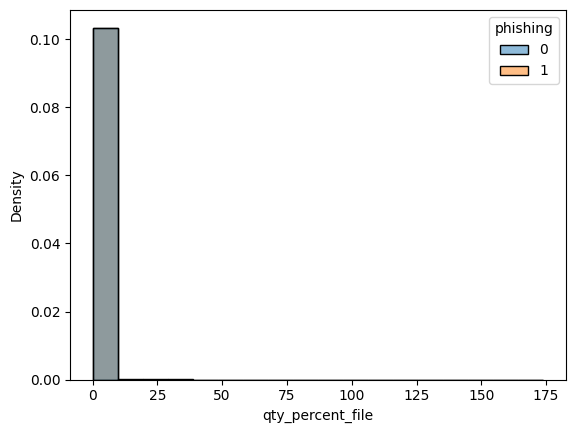

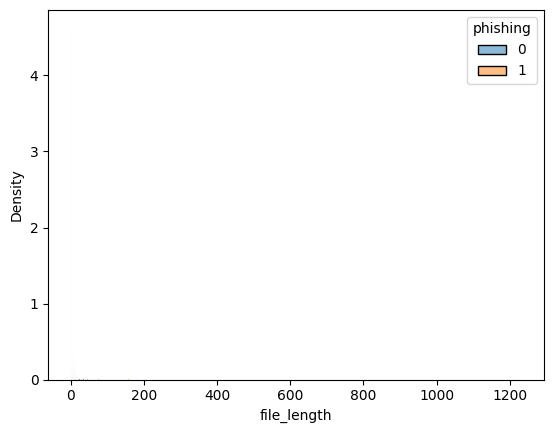

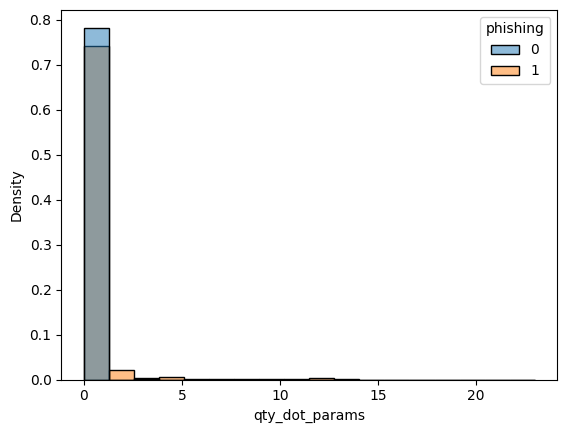

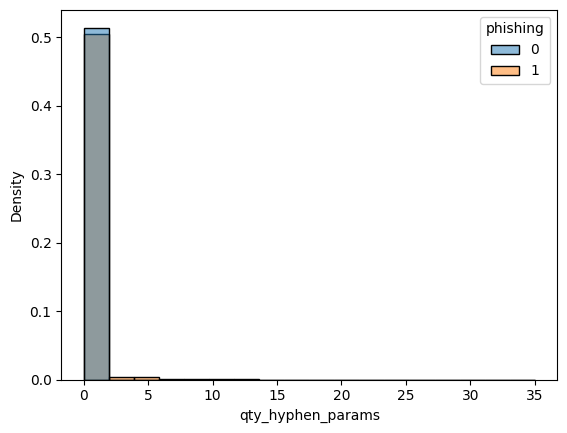

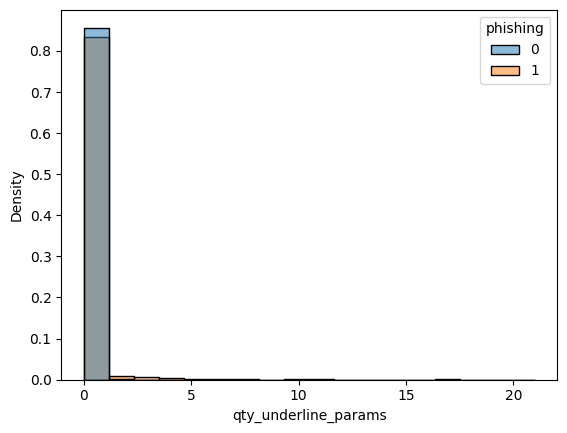

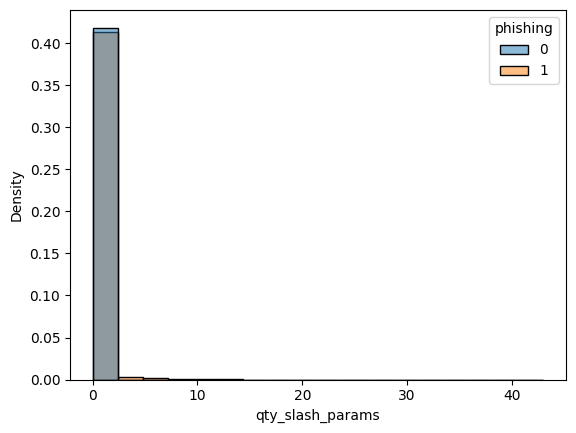

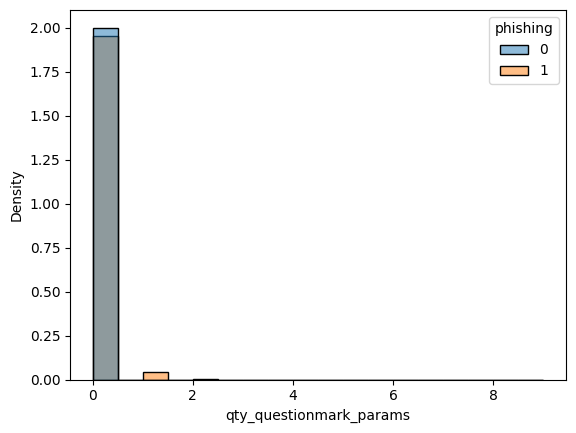

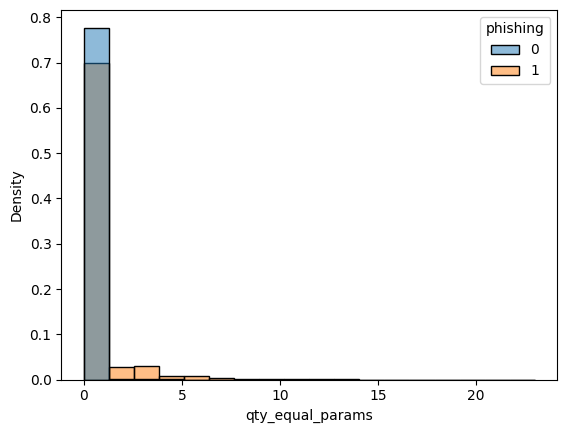

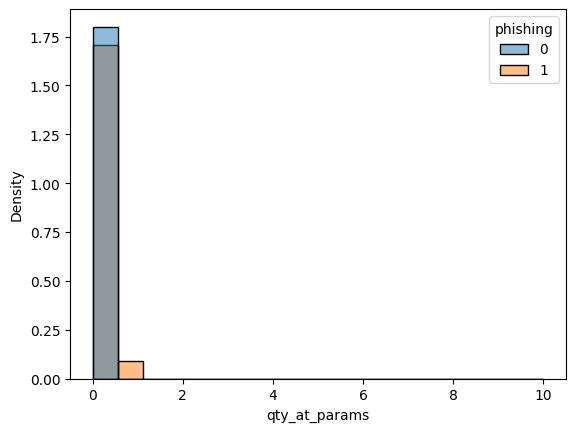

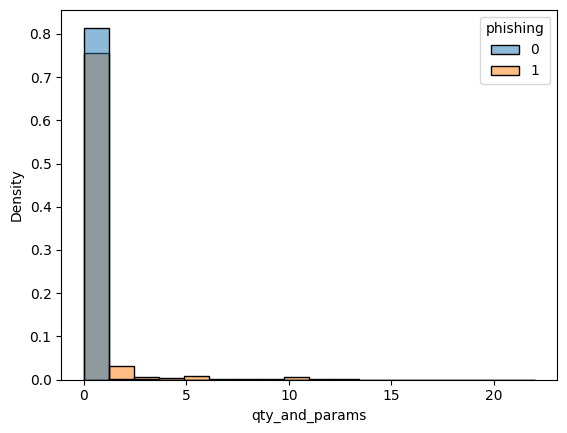

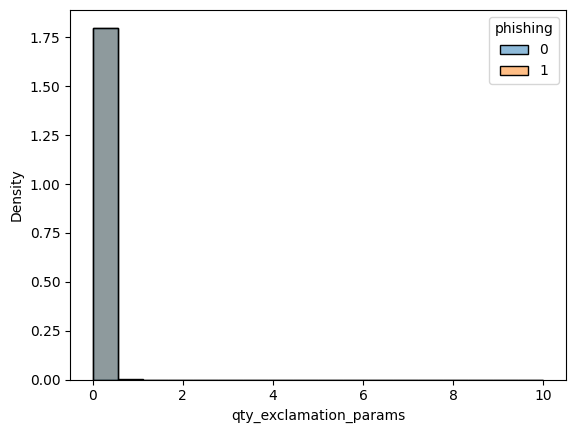

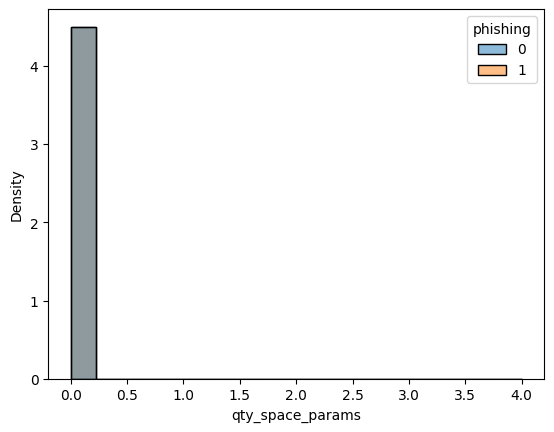

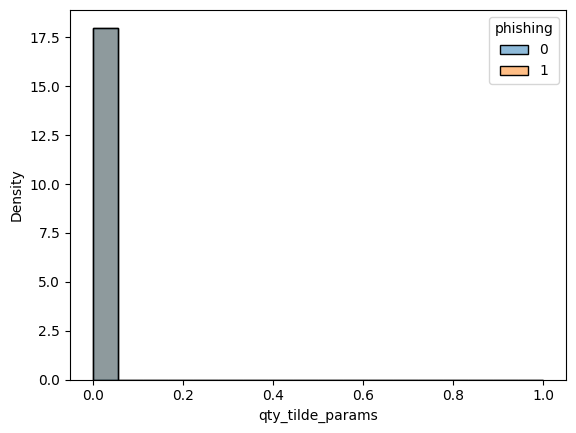

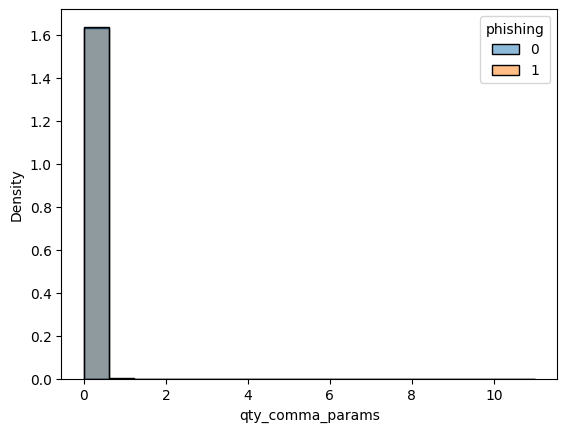

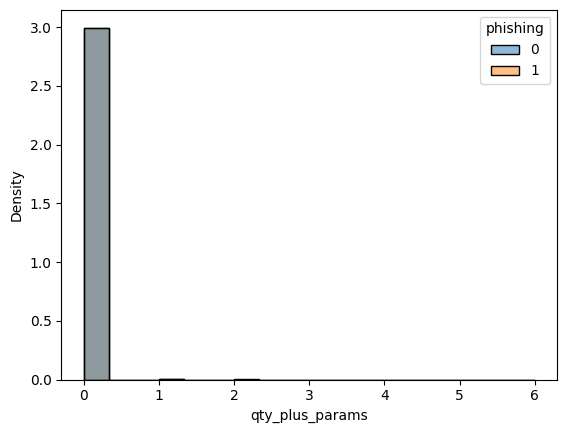

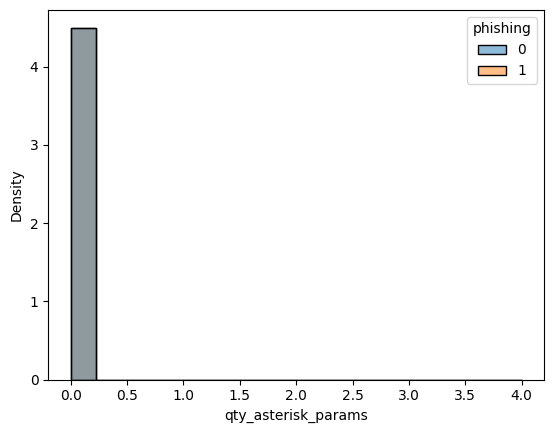

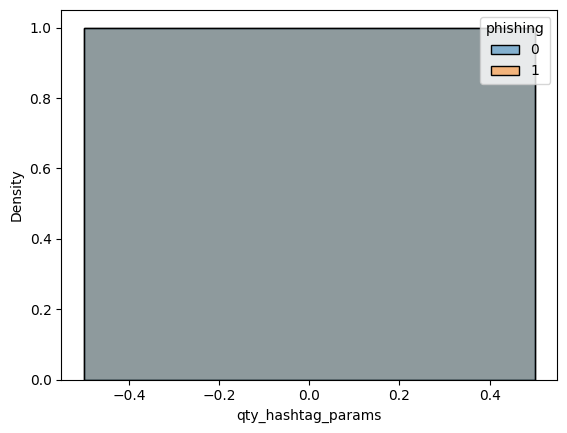

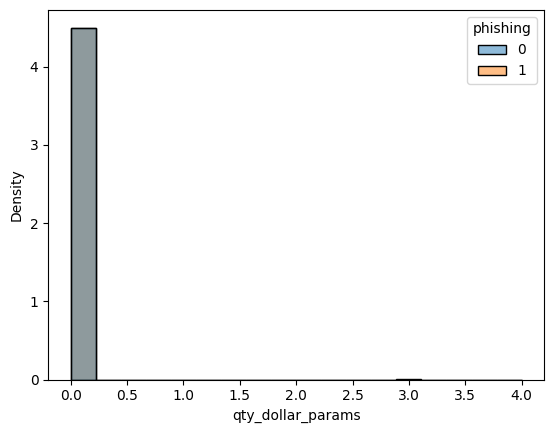

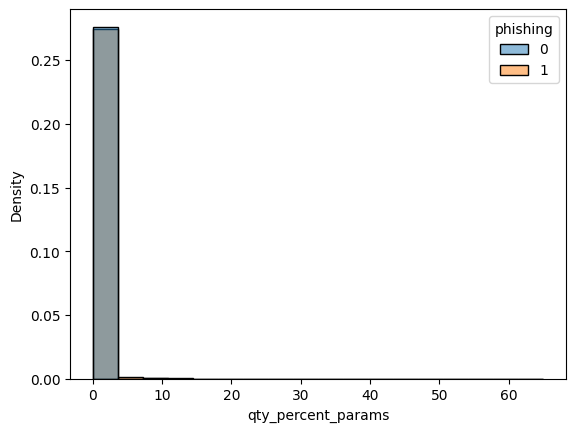

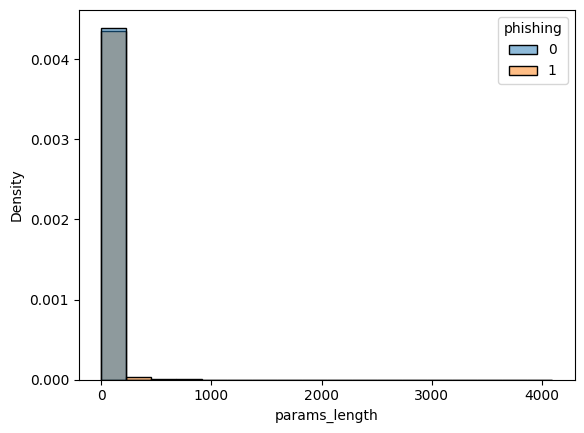

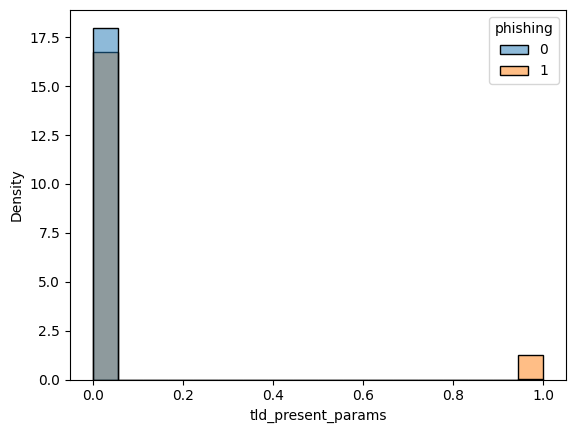

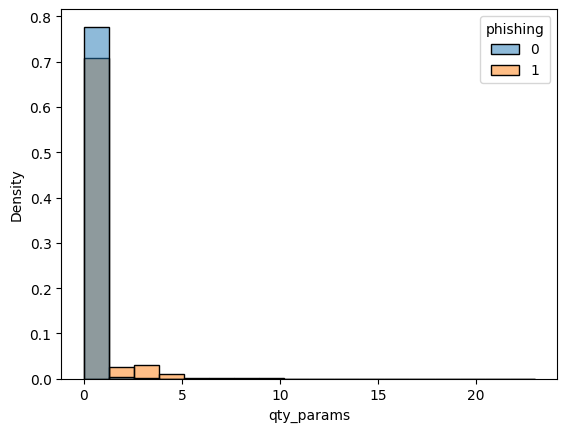

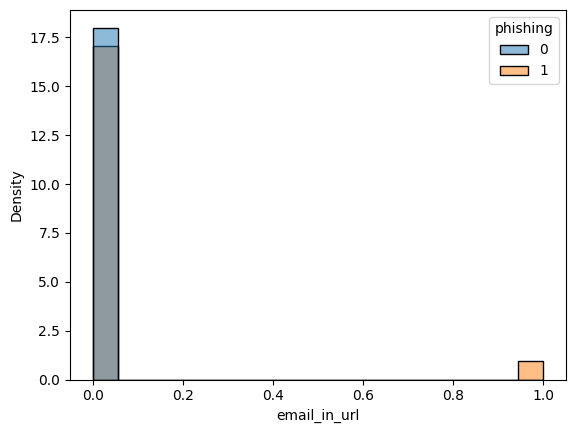

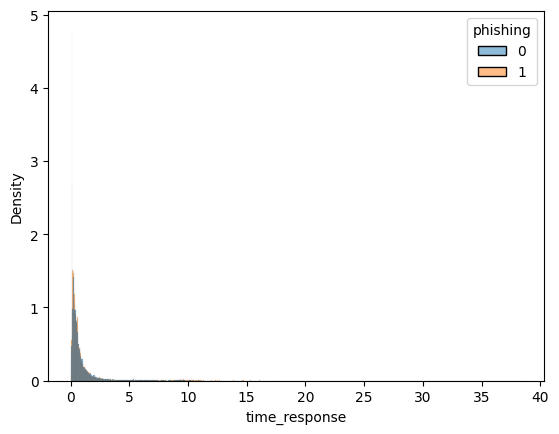

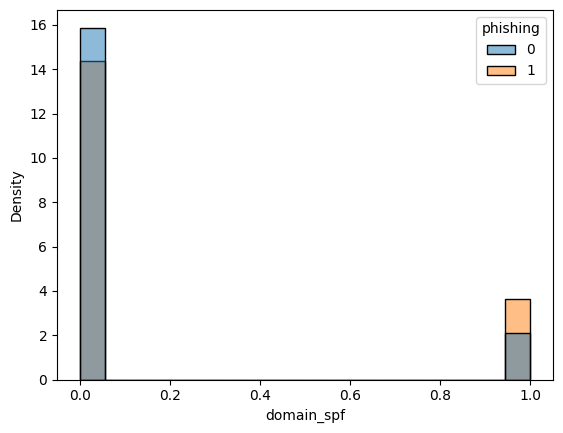

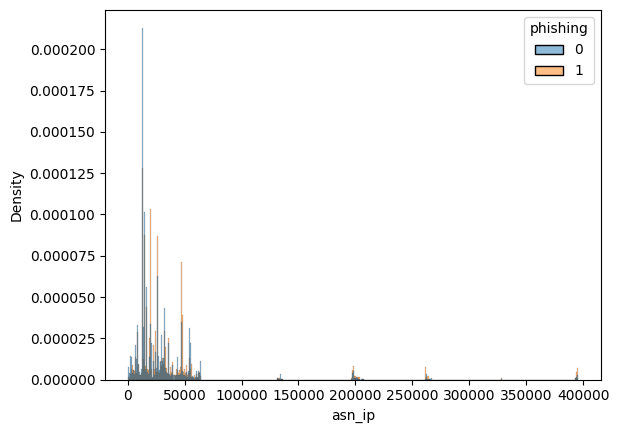

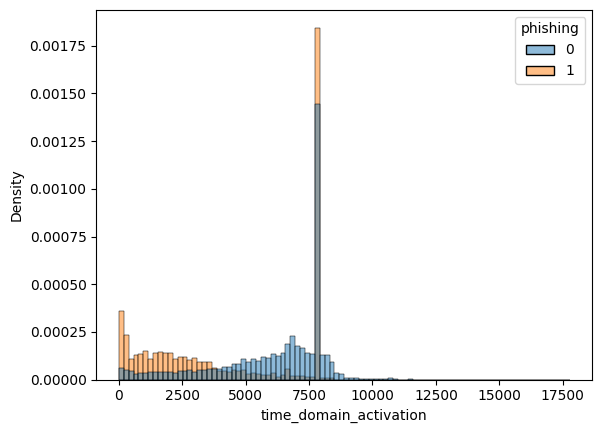

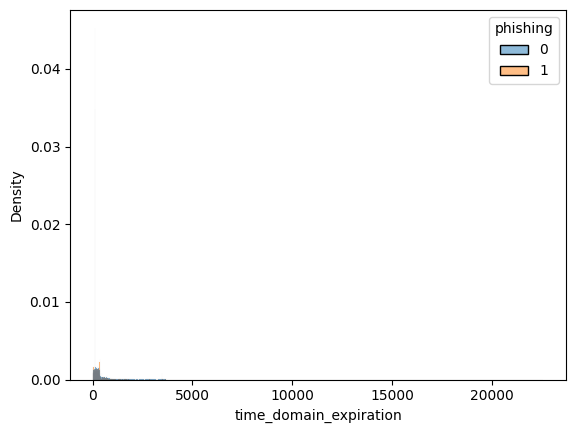

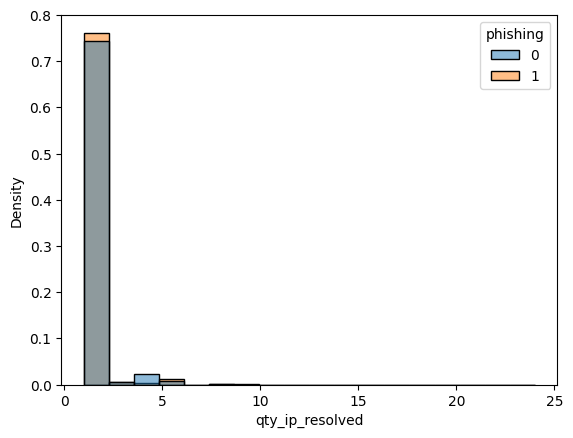

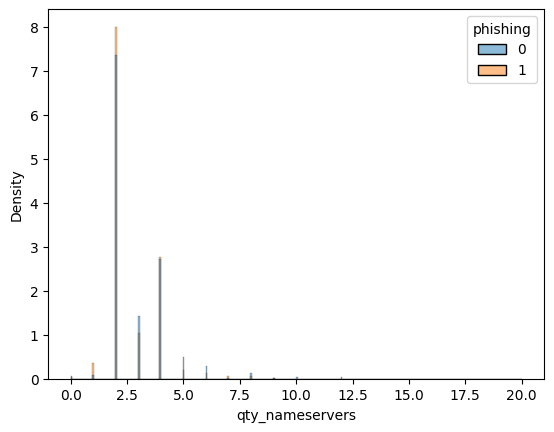

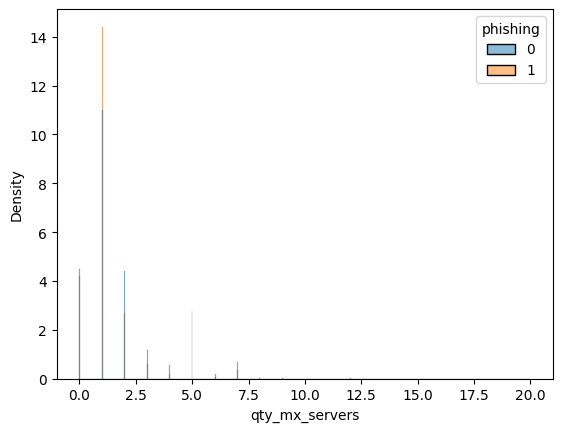

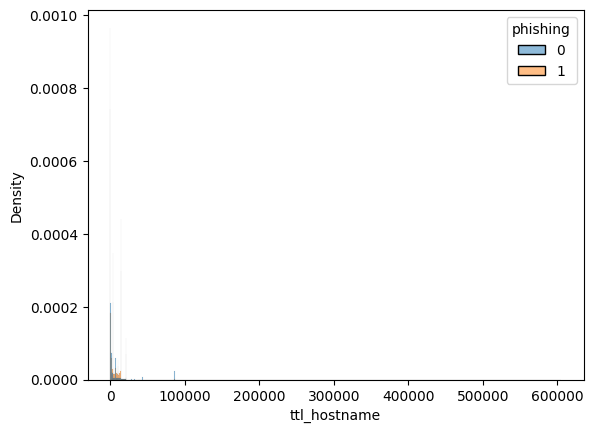

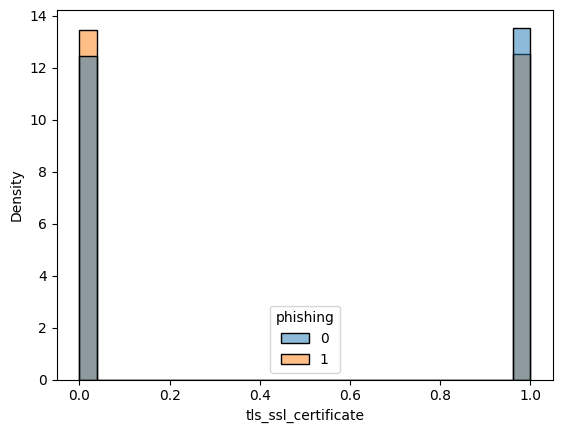

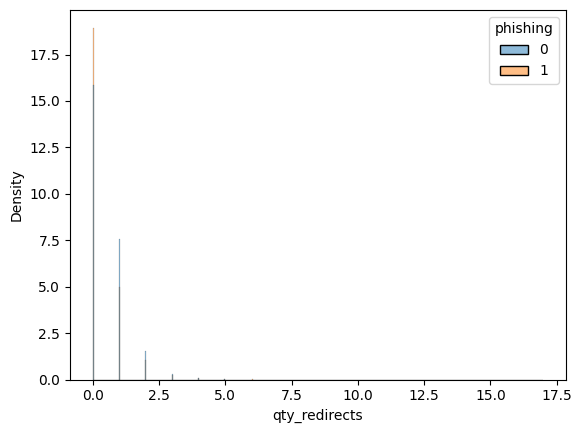

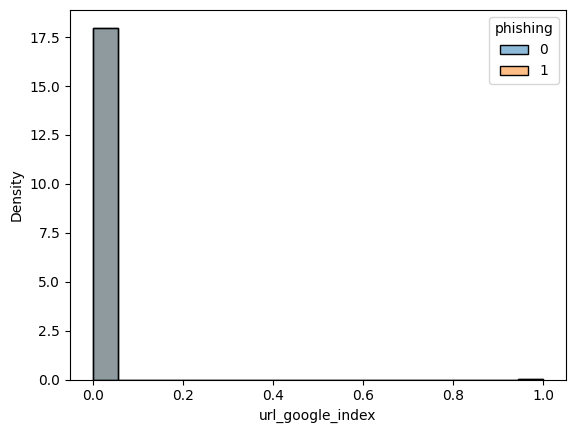

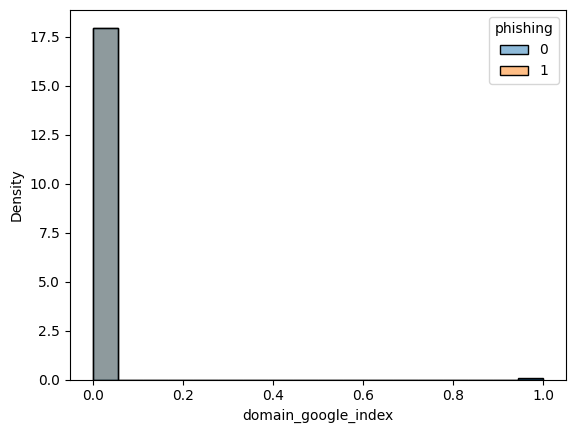

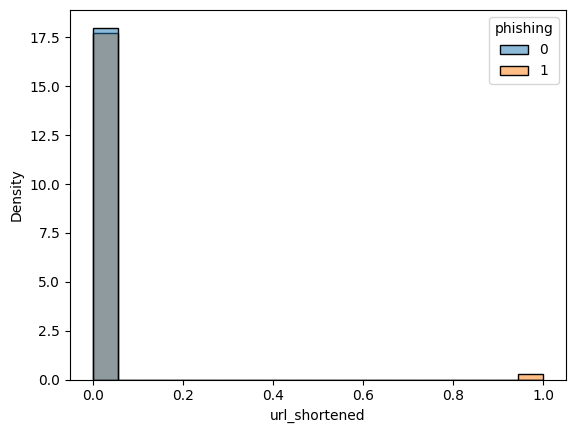

In [6]:
# plot the distribution of each feature in the dataset
# colored by the target variable
for col in data.columns:
    if col == 'phishing':
        continue
    sns.histplot(data, x=col, hue='phishing', stat='density', common_norm=False)
    plt.show()

In [7]:
# for each feature, that is not 0 or 1 apply a log transformation
for col in data.columns:
    if col == 'phishing':
        continue
    # if the feature is not binary
    if len(data[col].unique()) > 2:
        # if the feature is not 0 or 1
        if not set(data[col].unique()).issubset({0, 1}):
            data[col] = np.log(data[col] + 1)
        # plot the distribution of the feature
        # sns.histplot(data, x=col, hue='phishing', stat='density', common_norm=False)
        # plt.show()

## Filtering out features

If distributions for different values of the target variable are similar, we can remove the feature.
We can calculate the wasserstein distance between the distributions of the feature for different values of the target variable.

In [8]:
from scipy.stats import wasserstein_distance

# calculate the Wasserstein distance between the distributions of each feature
# for the two classes

to_drop = []
interesting_columns = []
for column in data.columns:
    if column == 'phishing':
        continue
    phishing = data[data['phishing'] == 1][column]
    non_phishing = data[data['phishing'] == 0][column]
    distance = wasserstein_distance(phishing, non_phishing)
    if distance < 0.03:
        to_drop.append(column)
        # print(f'{column}: {distance}')
        # sns.histplot(data, x=column, hue='phishing', stat='density', common_norm=False)
        # plt.show()
    elif distance > 0.5:
        interesting_columns.append(column)

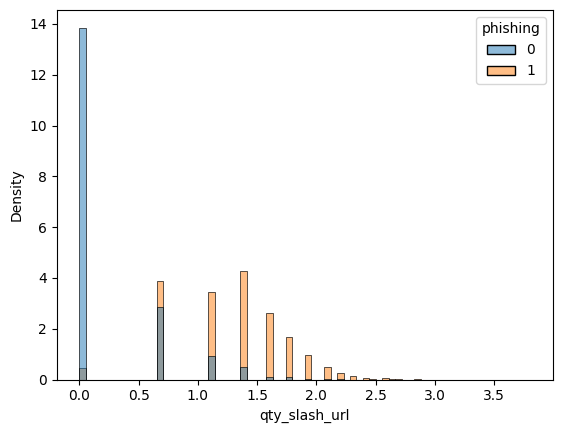

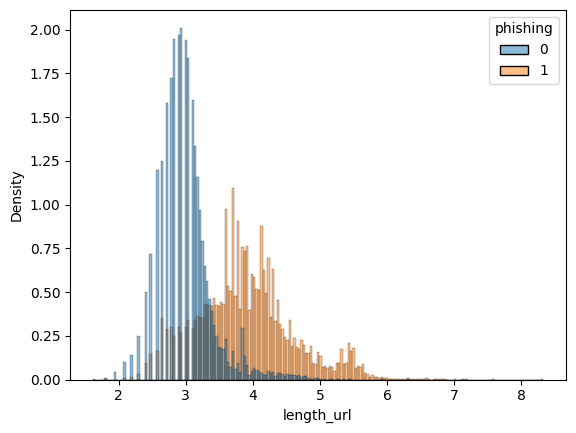

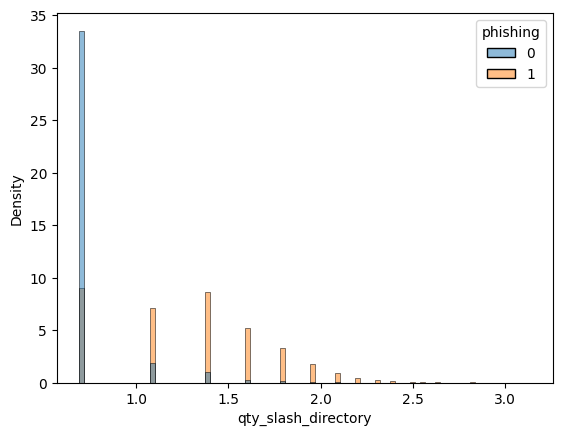

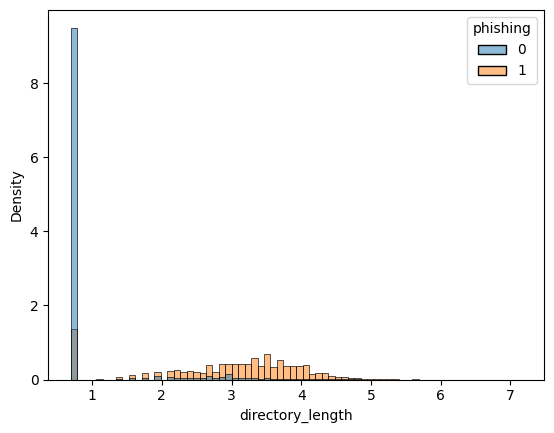

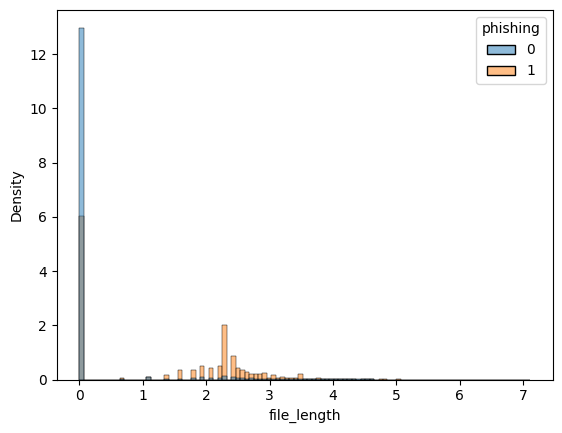

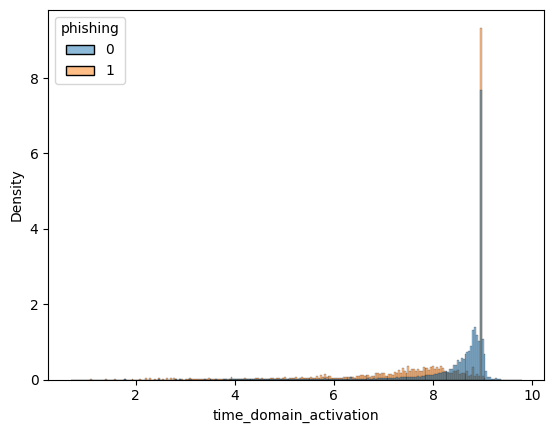

In [9]:
data_clean = data.drop(columns=to_drop)

for col in data_clean.columns:
    if col == 'phishing':
        continue
    if col in interesting_columns:
        sns.histplot(data_clean, x=col, hue='phishing', stat='density', common_norm=False)
        plt.show()

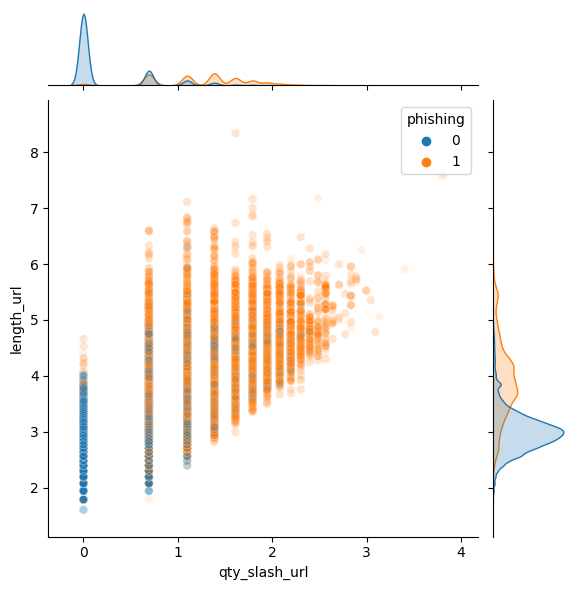

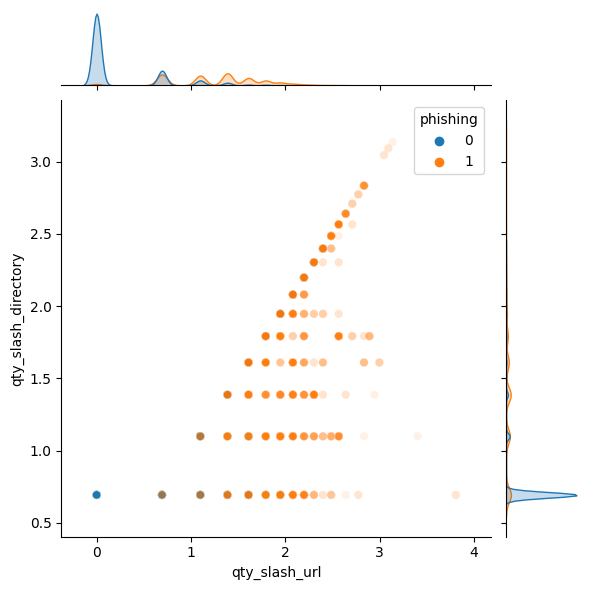

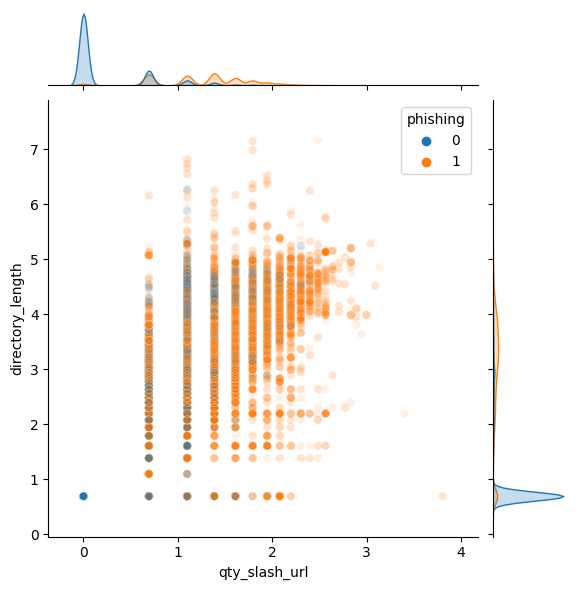

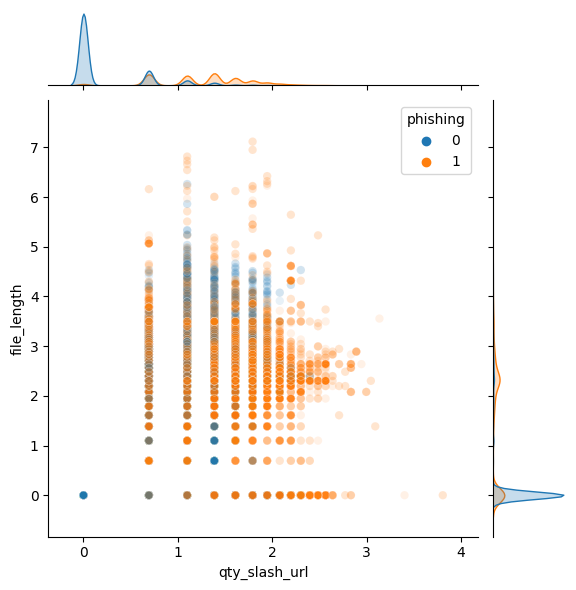

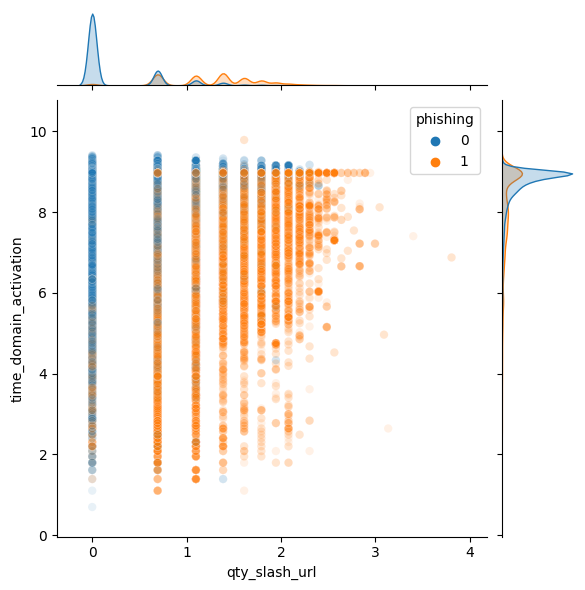

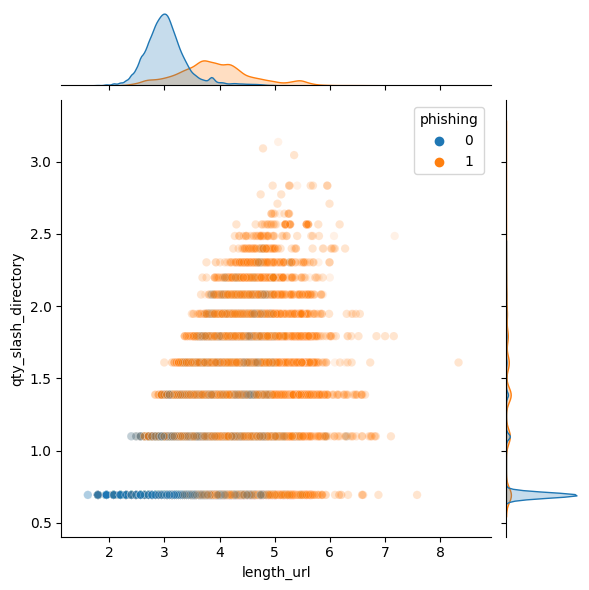

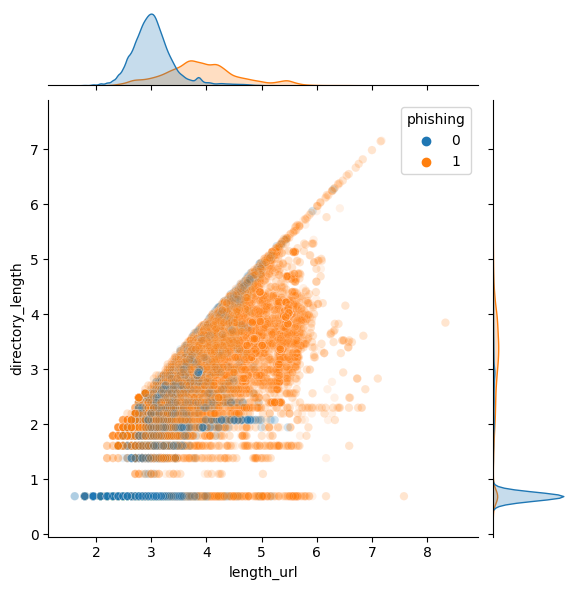

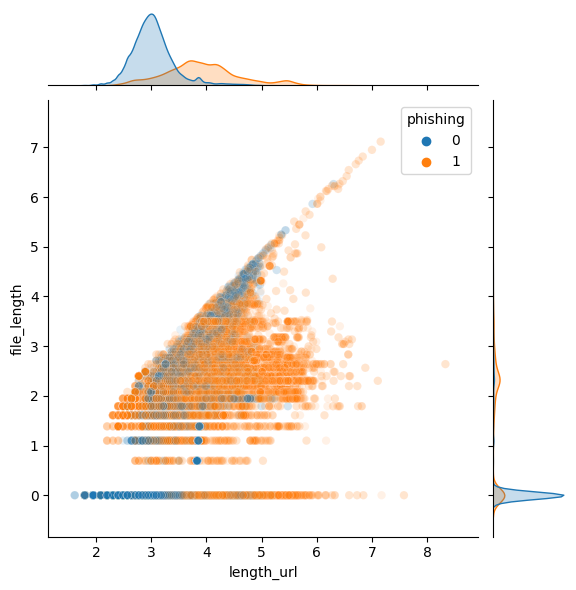

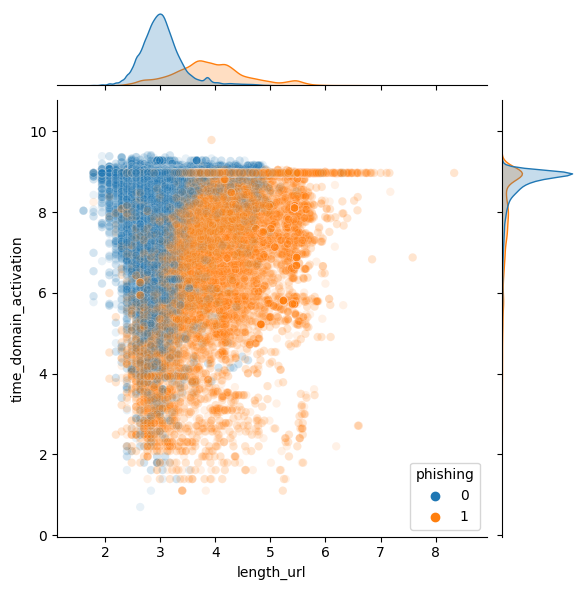

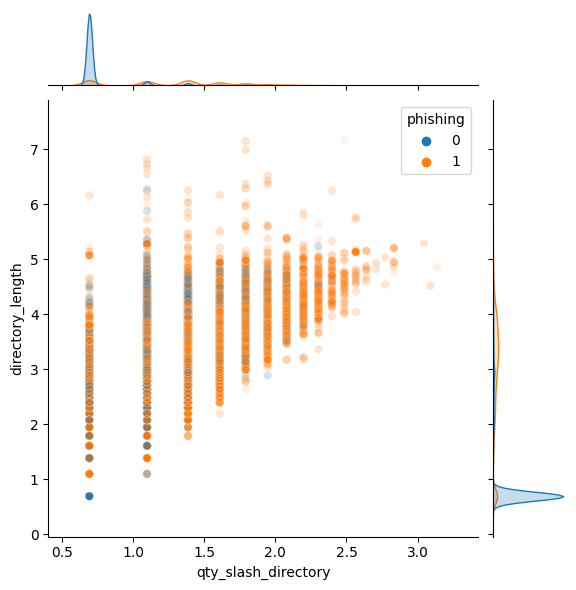

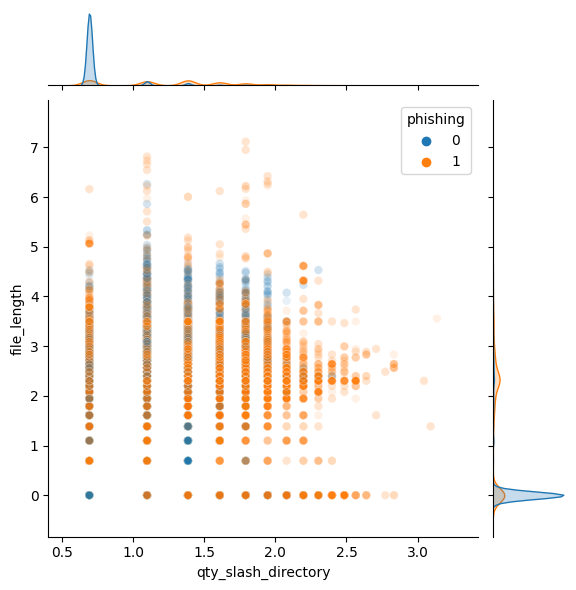

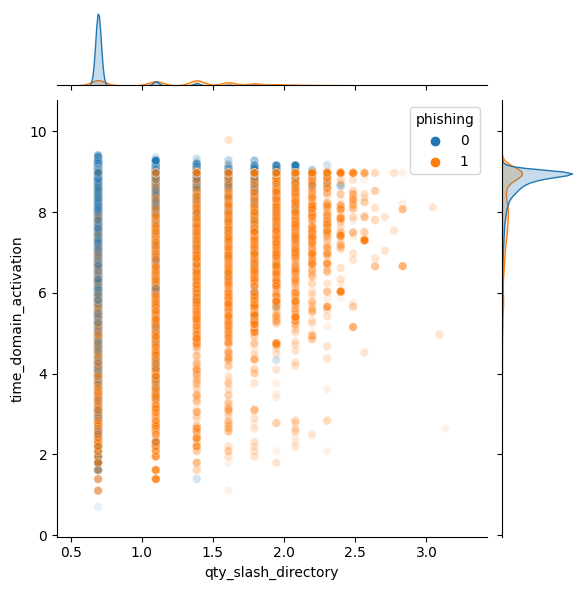

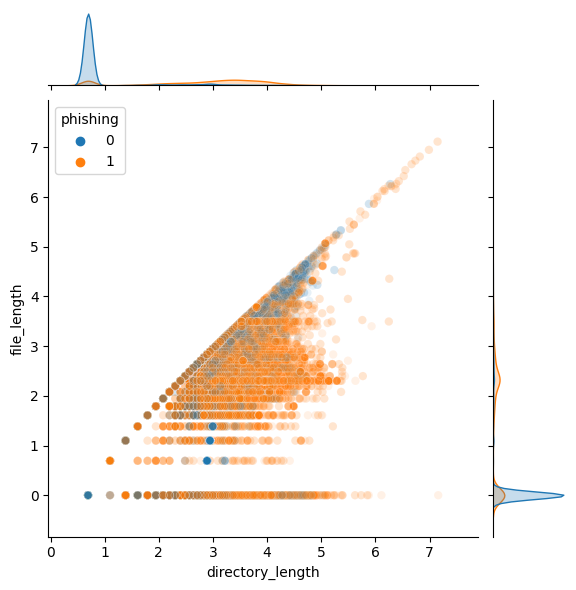

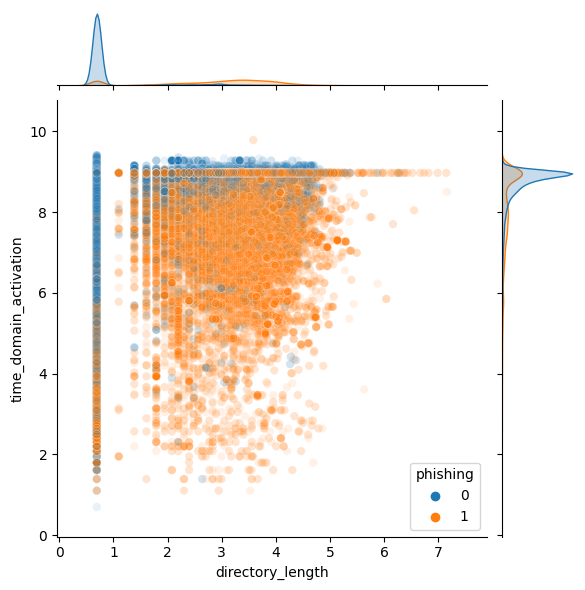

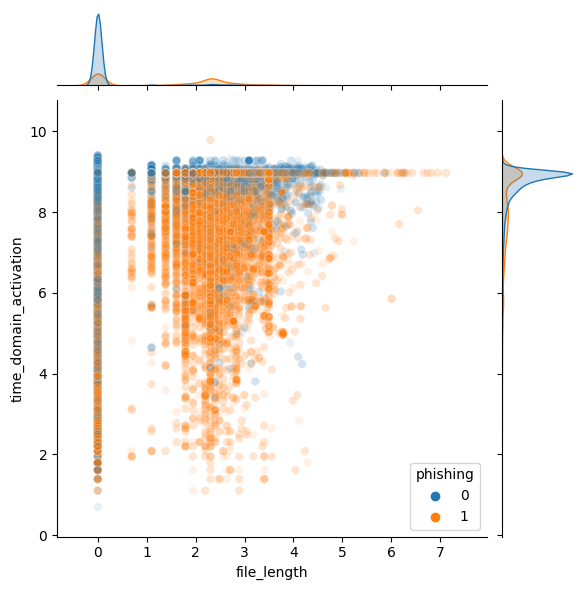

In [10]:
# print jointplot for each pair of interesting features
for i, col1 in enumerate(interesting_columns):
    for j, col2 in enumerate(interesting_columns):
        if i < j:
            # transparencey is 0.5
            sns.jointplot(data=data_clean, x=col1, y=col2, hue='phishing', alpha=0.1)
            plt.show()

## Preprocessing

In [11]:
from sklearn.model_selection import train_test_split

X = StandardScaler().fit_transform(data[interesting_columns])
y = data['phishing']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building the model

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     15391
           1       0.81      0.90      0.86     10549

    accuracy                           0.88     25940
   macro avg       0.87      0.88      0.87     25940
weighted avg       0.88      0.88      0.88     25940



<Axes: xlabel='Predicted', ylabel='Actual'>

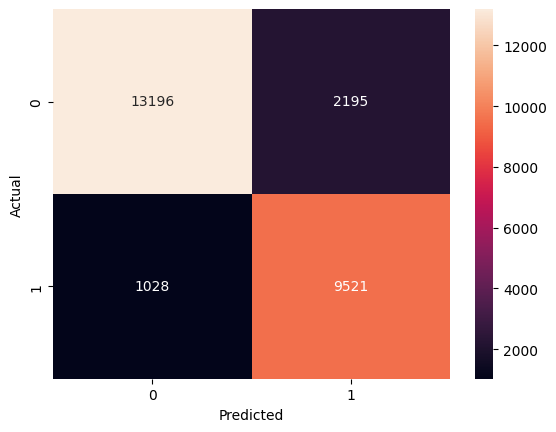

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(class_weight='balanced')
# weight classes to balance the data
# weights are chosen to be inversely proportional to the class frequencies
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
# confusion matrix
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion, annot=True, fmt="d")

# Note: recall with class reweightig shows better results

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     15391
           1       0.94      0.96      0.95     10549

    accuracy                           0.96     25940
   macro avg       0.95      0.96      0.96     25940
weighted avg       0.96      0.96      0.96     25940



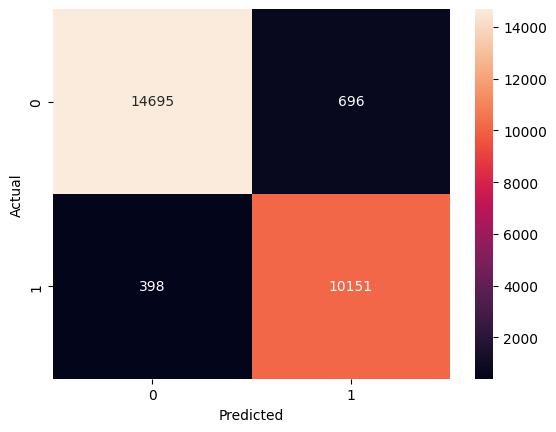

              precision    recall  f1-score   support

           0       0.94      0.93      0.94     15391
           1       0.90      0.92      0.91     10549

    accuracy                           0.93     25940
   macro avg       0.92      0.92      0.92     25940
weighted avg       0.93      0.93      0.93     25940



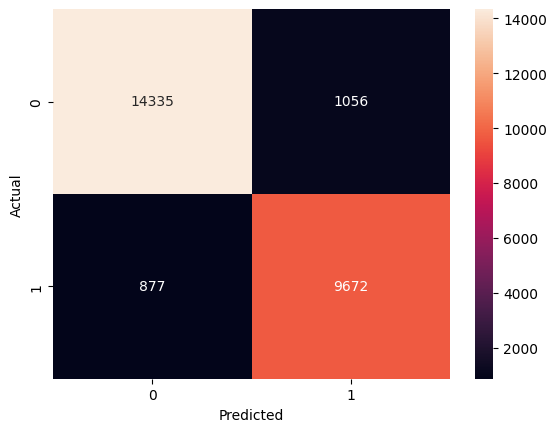

In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
# confusion matrix
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion, annot=True, fmt="d")
plt.show()

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
# confusion matrix
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion, annot=True, fmt="d")
plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


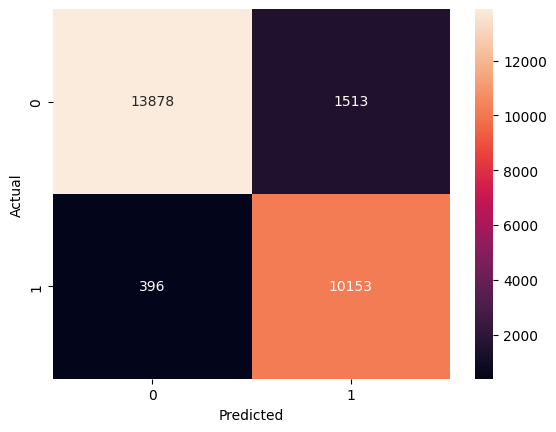

In [14]:
## fine tuning the Random Forest model
# best metric is recall
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(class_weight='balanced')
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='recall')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
# confusion matrix
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion, annot=True, fmt="d")
plt.show()

It looks like after perfoming cross validation, we can identify the wishing website with probability of ~0.96 (recall metric).  

## Simple Neural Network

2024-05-02 17:37:07.912396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
3243/3243 [==============================] - 4s 1ms/step - loss: 0.1163 - recall: 0.8443 - val_loss: 0.2200 - val_recall: 0.8660
Epoch 2/40
3243/3243 [==============================] - 3s 988us/step - loss: 0.1087 - recall: 0.8486 - val_loss: 0.2149 - val_recall: 0.8591
Epoch 3/40
3243/3243 [==============================] - 3s 999us/step - loss: 0.1066 - recall: 0.8508 - val_loss: 0.2090 - val_recall: 0.8867
Epoch 4/40
3243/3243 [==============================] - 3s 1ms/step - loss: 0.1052 - recall: 0.8523 - val_loss: 0.2226 - val_recall: 0.8461
Epoch 5/40
3243/3243 [==============================] - 3s 1ms/step - loss: 0.1040 - recall: 0.8543 - val_loss: 0.2205 - val_recall: 0.8380
Epoch 6/40
3243/3243 [==============================] - 3s 962us/step - loss: 0.1032 - recall: 0.8523 - val_loss: 0.2121 - val_recall: 0.8504
Epoch 7/40
3243/3243 [==============================] - 3s 963us/step - loss: 0.1021 - recall: 0.8540 - val_loss: 0.2100 - val_recall: 0.8472
Epoch 8/40
3

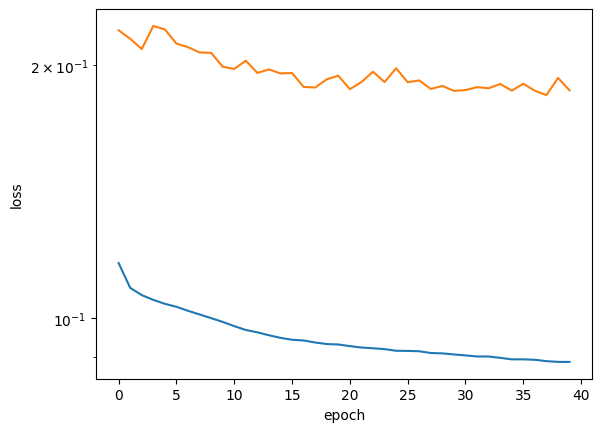

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Recall

def make_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = Sequential([
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid',
        bias_initializer=output_bias),
    ])

    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[Recall()])

    return model

pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
weights = {0: neg / len(y_train), 1: pos / len(y_train)}
initial_bias = np.log([pos/neg])

model = make_model(initial_bias)
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), class_weight=weights)
# plot the training and validation loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()



811/811 [==============================] - 0s 453us/step


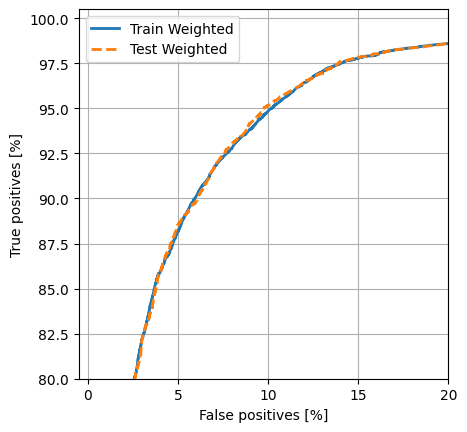

In [16]:
import sklearn

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)
plot_roc("Train Weighted", y_train, y_pred_train)
plot_roc("Test Weighted", y_test, y_pred, linestyle='--')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     15391
           1       0.92      0.89      0.90     10549

    accuracy                           0.92     25940
   macro avg       0.92      0.92      0.92     25940
weighted avg       0.92      0.92      0.92     25940



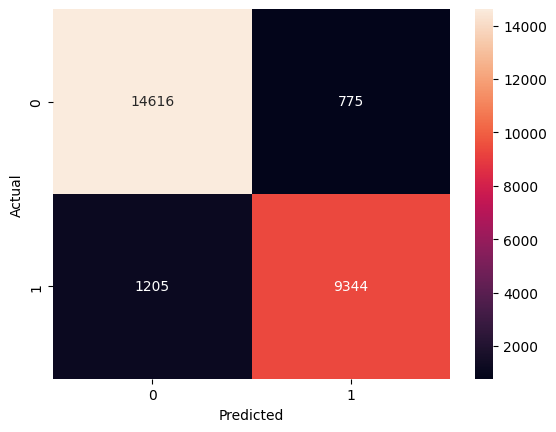

In [23]:
#convert continuous prediction to binary
y_pred_binary = np.where(y_pred > 0.5, 1, 0).flatten()
print(classification_report(y_test, y_pred_binary))
# confusion matrix
confusion = pd.crosstab(y_test, y_pred_binary, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion, annot=True, fmt="d")
plt.show()